# 1. Setup: Import Libraries and Load Data


## 1.1. Import Libraries

In [ ]:
# ============================================================
# ALL IMPORTS
# ============================================================

# Standard library imports
import os
import random
import warnings
import itertools
import math
from collections import Counter

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical analysis and time series
from statsmodels.tsa.stattools import adfuller, kpss, acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from scipy import signal

# Machine Learning - scikit-learn
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler

# Deep Learning - PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Settings
warnings.filterwarnings('ignore')

In [ ]:
def set_seed(seed):
    """
    Function to set seed for all libraries to ensure reproducible results.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    # If using GPU (CUDA)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) # for multi-GPU
        # This line may slow down training slightly but ensures consistency
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    os.environ['PYTHONHASHSEED'] = str(seed)
    print(f"Seed has been set to: {seed}")

## 1.2. Load Data

In [ ]:
df_org = pd.read_csv("Electronic_sales_Sep2023-Sep2024.csv")
df = df_org.copy()

# 2. Exploratory Data Analysis



## 2.1. Data Understanding

In [ ]:
df.shape

(20000, 16)

In [ ]:
df.head()

,Customer ID,Age,Gender,Loyalty Member,Product Type,SKU,Rating,Order Status,Payment Method,Total Price,Unit Price,Quantity,Purchase Date,Shipping Type,Add-ons Purchased,Add-on Total
0,1000,53,Male,No,Smartphone,SKU1004,2,Cancelled,Credit Card,5538.33,791.19,7,2024-03-20,Standard,"Accessory,Accessory,Accessory",40.21
1,1000,53,Male,No,Tablet,SKU1002,3,Completed,Paypal,741.09,247.03,3,2024-04-20,Overnight,Impulse Item,26.09
2,1002,41,Male,No,Laptop,SKU1005,3,Completed,Credit Card,1855.84,463.96,4,2023-10-17,Express,NaN,0.00
3,1002,41,Male,Yes,Smartphone,SKU1004,2,Completed,Cash,3164.76,791.19,4,2024-08-09,Overnight,"Impulse Item,Impulse Item",60.16
4,1003,75,Male,Yes,Smartphone,SKU1001,5,Completed,Cash,41.50,20.75,2,2024-05-21,Express,Accessory,35.56


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Customer ID        20000 non-null  int64  
 1   Age                20000 non-null  int64  
 2   Gender             19999 non-null  object 
 3   Loyalty Member     20000 non-null  object 
 4   Product Type       20000 non-null  object 
 5   SKU                20000 non-null  object 
 6   Rating             20000 non-null  int64  
 7   Order Status       20000 non-null  object 
 8   Payment Method     20000 non-null  object 
 9   Total Price        20000 non-null  float64
 10  Unit Price         20000 non-null  float64
 11  Quantity           20000 non-null  int64  
 12  Purchase Date      20000 non-null  object 
 13  Shipping Type      20000 non-null  object 
 14  Add-ons Purchased  15132 non-null  object 
 15  Add-on Total       20000 non-null  float64
dtypes: float64(3), int64(4

In [ ]:
df.describe()

,Customer ID,Age,Rating,Total Price,Unit Price,Quantity,Add-on Total
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,10483.526550,48.994100,3.093950,3180.133419,578.631867,5.485550,62.244848
std,5631.732525,18.038745,1.223764,2544.978675,312.274076,2.870854,58.058431
min,1000.000000,18.000000,1.000000,20.750000,20.750000,1.000000,0.000000
25%,5478.000000,33.000000,2.000000,1139.680000,361.180000,3.000000,7.615000
50%,10499.500000,49.000000,3.000000,2534.490000,463.960000,5.000000,51.700000
75%,15504.000000,65.000000,4.000000,4639.600000,791.190000,8.000000,93.842500
max,19998.000000,80.000000,5.000000,11396.800000,1139.680000,10.000000,292.770000


In [ ]:
nunique_df = df.nunique().reset_index()
nunique_df.columns = ['Column', 'Unique_Count']
nunique_df

,Column,Unique_Count
0,Customer ID,12136
1,Age,63
2,Gender,2
3,Loyalty Member,2
4,Product Type,5
5,SKU,10
6,Rating,5
7,Order Status,2
8,Payment Method,6
9,Total Price,104


## 2.2. Data Cleaning

In [ ]:
# Check duplicate value
df.duplicated().sum()

0

In [ ]:
# Check null values
df_check = df.isnull().sum().to_frame('missing_count')
df_check['percentage_missing'] = (df_check['missing_count'] / len(df)) * 100
print(df_check)

                   missing_count  percentage_missing
Customer ID                    0               0.000
Age                            0               0.000
Gender                         1               0.005
Loyalty Member                 0               0.000
Product Type                   0               0.000
SKU                            0               0.000
Rating                         0               0.000
Order Status                   0               0.000
Payment Method                 0               0.000
Total Price                    0               0.000
Unit Price                     0               0.000
Quantity                       0               0.000
Purchase Date                  0               0.000
Shipping Type                  0               0.000
Add-ons Purchased           4868              24.340
Add-on Total                   0               0.000


In [ ]:
# Delete null values
df = df.dropna(subset=['Gender'])

In [ ]:
# Convert Purchase date to datetime
df['Purchase date'] = pd.to_datetime(df['Purchase Date'])
df['Month'] = df['Purchase date'].dt.month
df['Year'] = df['Purchase date'].dt.year
df['Day of week'] = df['Purchase date'].dt.day_name()
df['Week number'] = df['Purchase date'].dt.isocalendar().week

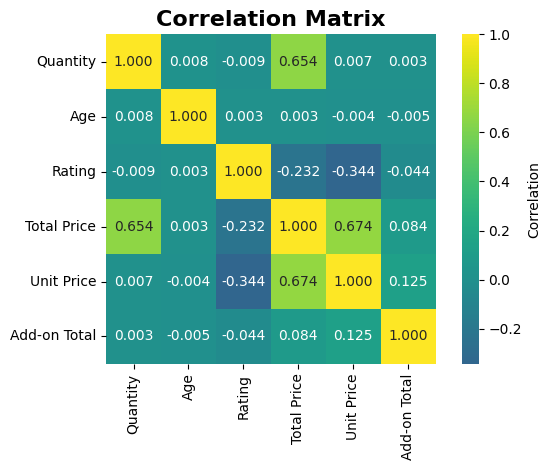

In [ ]:
numerical_cols = ['Quantity', 'Age', 'Rating', 'Total Price', 'Unit Price', 'Add-on Total']
correlation_matrix = df[numerical_cols].corr()
sns.heatmap(correlation_matrix,
            annot=True,
            cmap='viridis',
            center=0,
            square=True,
            fmt='.3f',
            cbar_kws={'label': 'Correlation'})

plt.title('Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 2.3. Data Exploration

In [ ]:
# Config
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
sns.set_palette("husl")

### 2.3.1. Trend Analysis

<Figure size 1400x600 with 0 Axes>

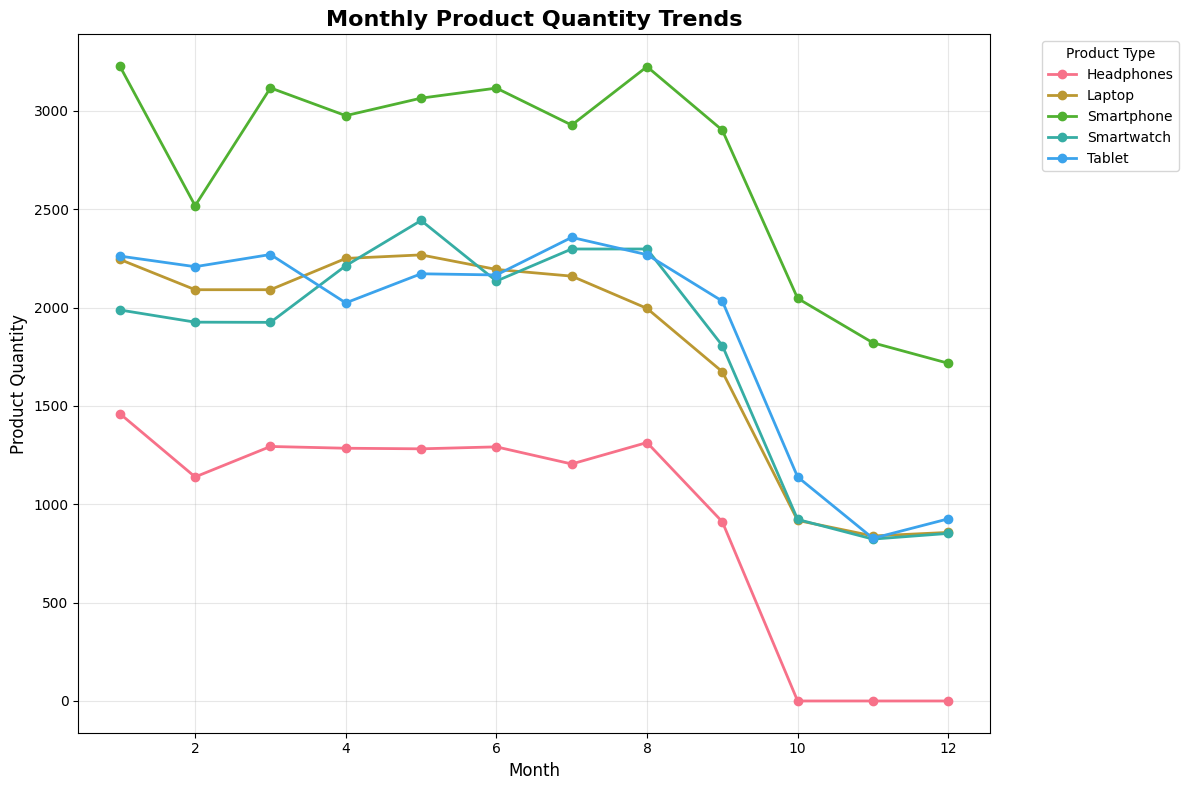

In [ ]:
# Product quantity by product type and month
plt.figure(figsize=(14, 6))
monthly_product = df.groupby(['Month', 'Product Type'])['Quantity'].sum().unstack(fill_value=0)
monthly_product.plot(kind='line', marker='o', linewidth=2, markersize=6)
plt.title('Monthly Product Quantity Trends', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Product Quantity', fontsize=12)
plt.legend(title='Product Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

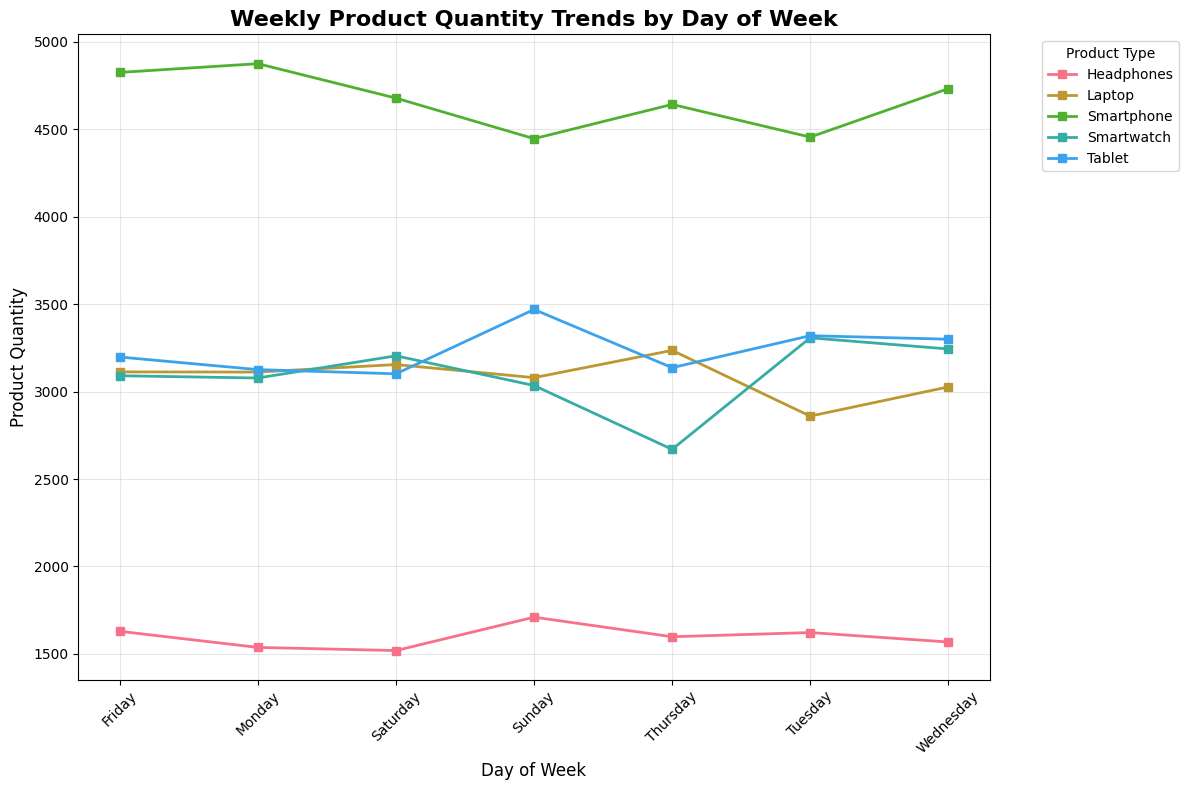

In [ ]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_product = df.groupby(['Day of week', 'Product Type'])['Quantity'].sum().unstack(fill_value=0)
weekly_product.plot(kind='line', marker='s', linewidth=2, markersize=6)
plt.title('Weekly Product Quantity Trends by Day of Week', fontsize=16, fontweight='bold')
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Product Quantity', fontsize=12)
plt.legend(title='Product Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

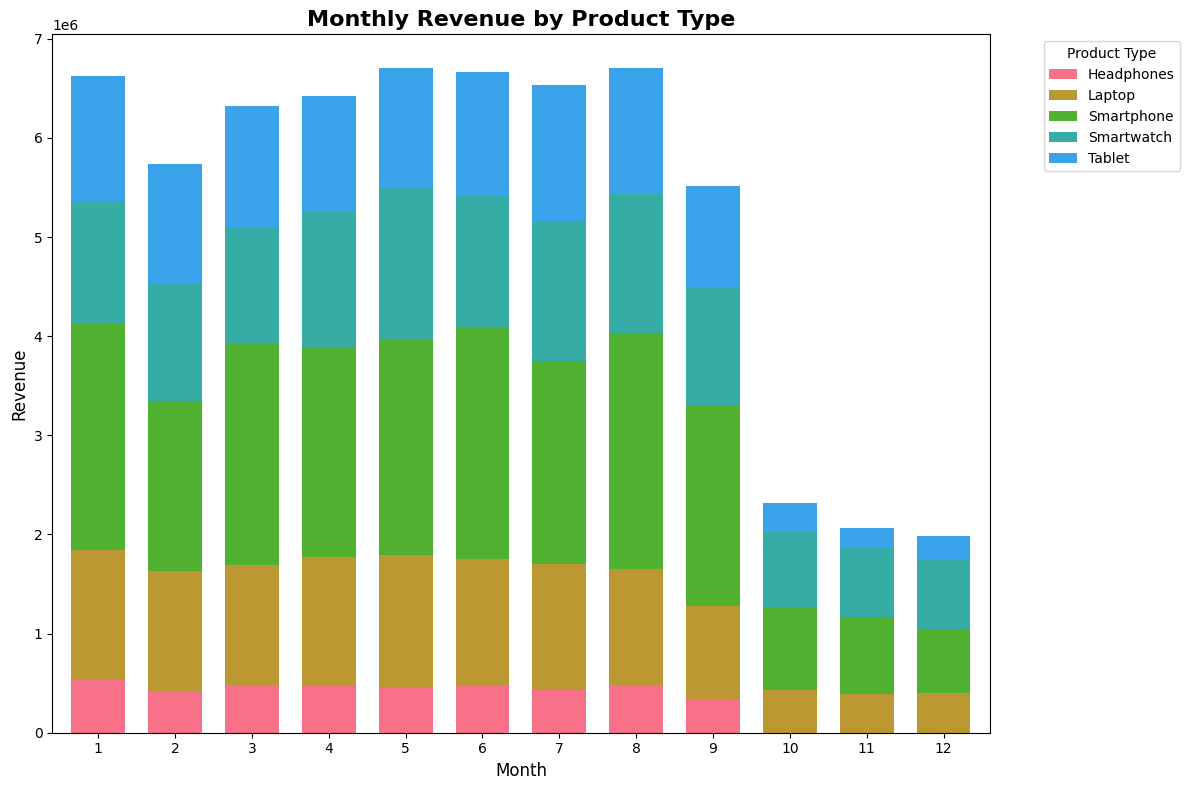

In [ ]:
# Monthly revenue by category
plt.figure(figsize=(12, 8))
monthly_revenue = df.groupby(['Month', 'Product Type'])['Total Price'].sum().unstack(fill_value=0)
ax = monthly_revenue.plot(kind='bar', stacked=True, width=0.7)
plt.title('Monthly Revenue by Product Type', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Revenue', fontsize=12)
plt.legend(title='Product Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

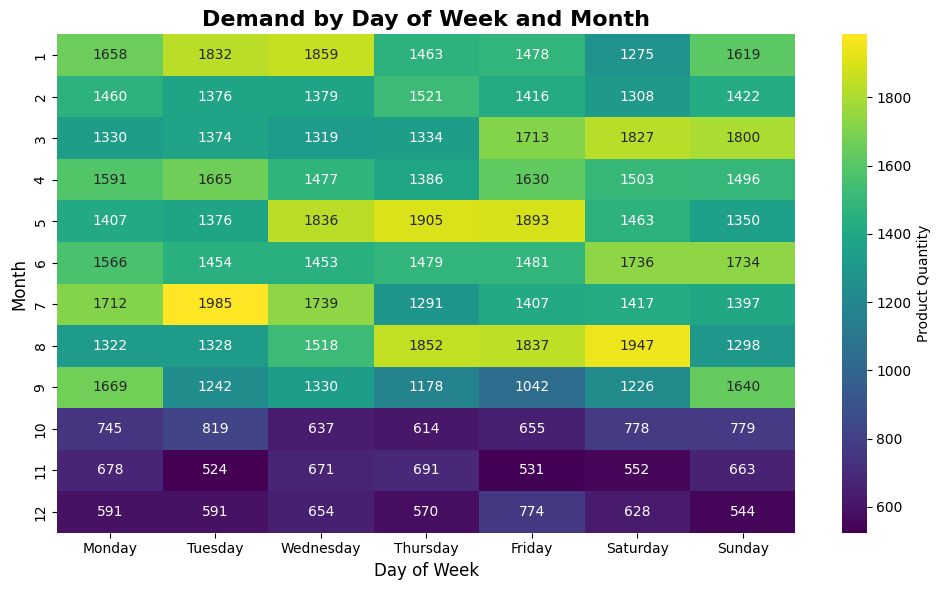

In [ ]:
# Heatmap: Demand by day of week and month
plt.figure(figsize=(10, 6))
heatmap_data = df.groupby(['Month', 'Day of week'])['Quantity'].sum().unstack(fill_value=0)
heatmap_data = heatmap_data.reindex(columns=day_order, fill_value=0)
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='viridis', cbar_kws={'label': 'Product Quantity'})
plt.title('Demand by Day of Week and Month', fontsize=16, fontweight='bold')
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Month', fontsize=12)
plt.tight_layout()
plt.show()

### 2.3.2. Revenue Analysis

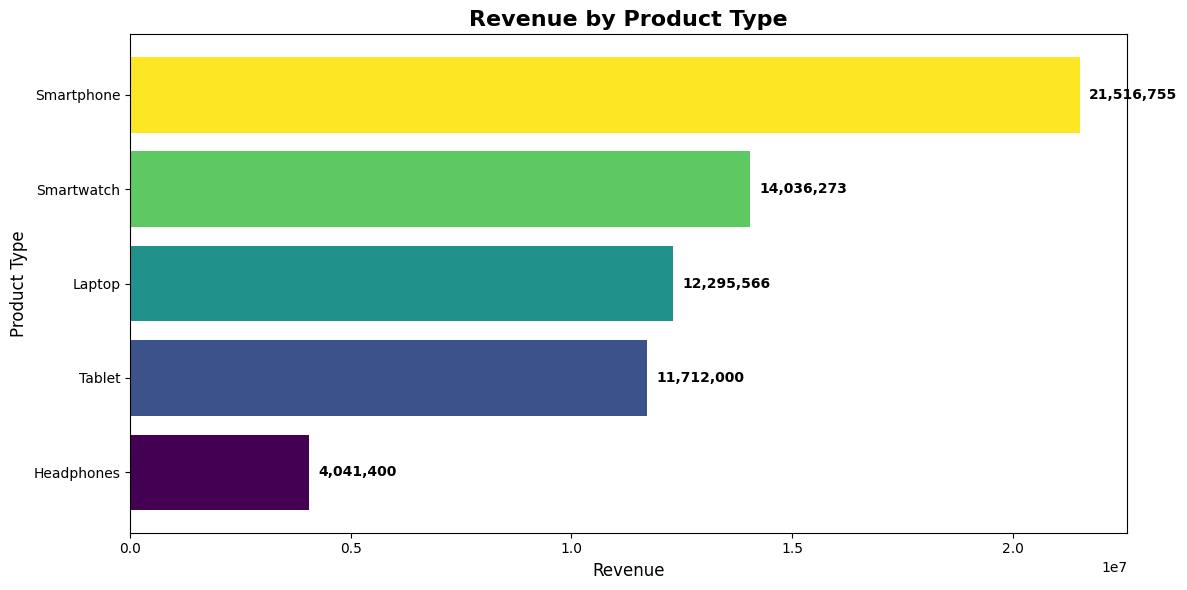

In [ ]:
# Compare revenue by product category
plt.figure(figsize=(12, 6))
revenue_by_product = df.groupby('Product Type')['Total Price'].sum().sort_values(ascending=True)
bars = plt.barh(range(len(revenue_by_product)), revenue_by_product.values,
                color=plt.cm.viridis(np.linspace(0, 1, len(revenue_by_product))))
plt.yticks(range(len(revenue_by_product)), revenue_by_product.index)
plt.title('Revenue by Product Type', fontsize=16, fontweight='bold')
plt.xlabel('Revenue', fontsize=12)
plt.ylabel('Product Type', fontsize=12)
# Add values on each bar
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + max(revenue_by_product)*0.01, bar.get_y() + bar.get_height()/2,
             f'{width:,.0f}', ha='left', va='center', fontweight='bold')
plt.tight_layout()
plt.show()

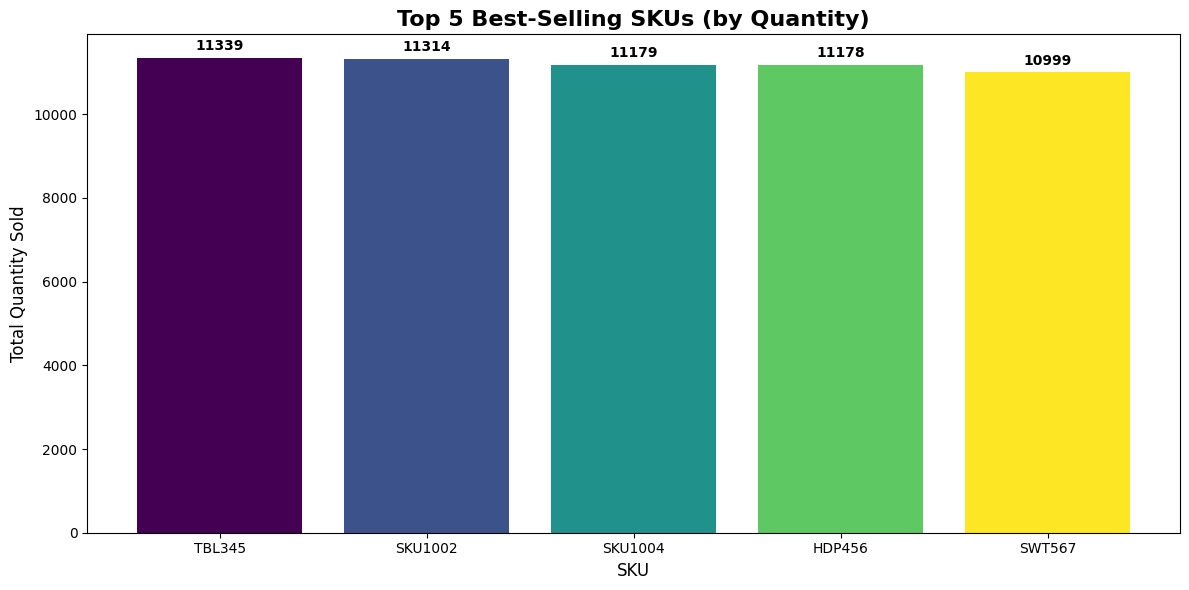

In [ ]:
# Top 5 best-selling SKUs (by Quantity)
plt.figure(figsize=(12, 6))
top_sku = df.groupby('SKU')['Quantity'].sum().sort_values(ascending=False).head(5)
bars = plt.bar(range(len(top_sku)), top_sku.values,
               color=plt.cm.viridis(np.linspace(0, 1, len(top_sku))))
plt.xticks(range(len(top_sku)), top_sku.index)
plt.title('Top 5 Best-Selling SKUs (by Quantity)', fontsize=16, fontweight='bold')
plt.xlabel('SKU', fontsize=12)
plt.ylabel('Total Quantity Sold', fontsize=12)
# Add values on each bar
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + max(top_sku)*0.01,
             f'{int(height)}', ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()

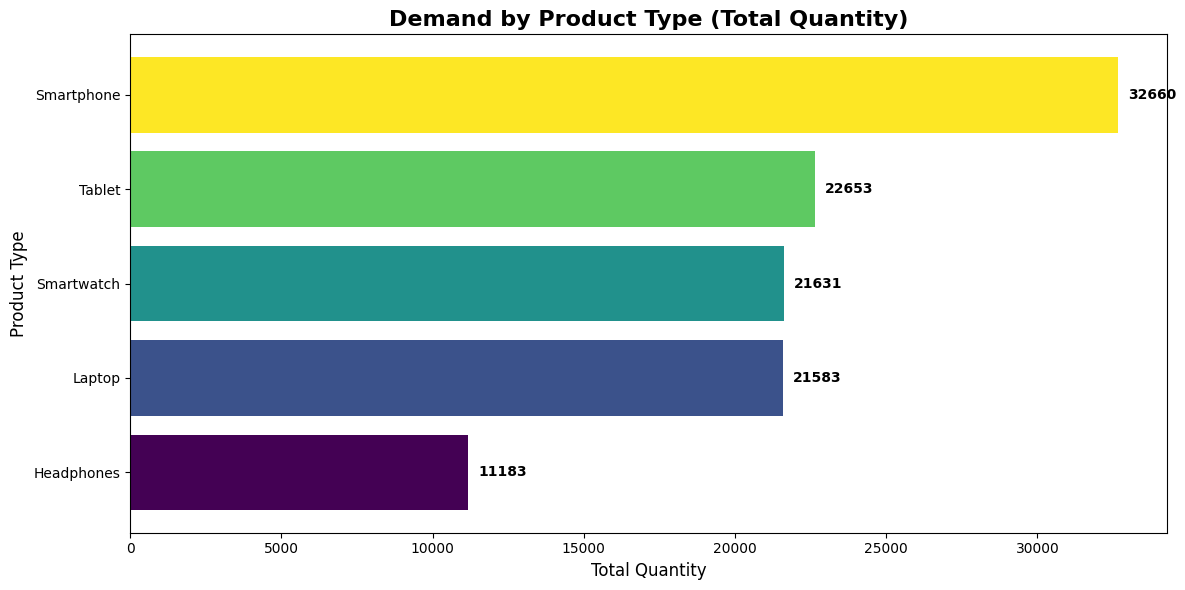

In [ ]:
# Product Type demand (by Quantity)
plt.figure(figsize=(12, 6))
demand_by_product = df.groupby('Product Type')['Quantity'].sum().sort_values(ascending=True)
bars = plt.barh(range(len(demand_by_product)), demand_by_product.values,
                color=plt.cm.viridis(np.linspace(0, 1, len(demand_by_product))))
plt.yticks(range(len(demand_by_product)), demand_by_product.index)
plt.title('Demand by Product Type (Total Quantity)', fontsize=16, fontweight='bold')
plt.xlabel('Total Quantity', fontsize=12)
plt.ylabel('Product Type', fontsize=12)
# Add values on each bar
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + max(demand_by_product)*0.01, bar.get_y() + bar.get_height()/2,
             f'{int(width)}', ha='left', va='center', fontweight='bold')
plt.tight_layout()
plt.show()

### 2.3.3. Factors Affecting Orders

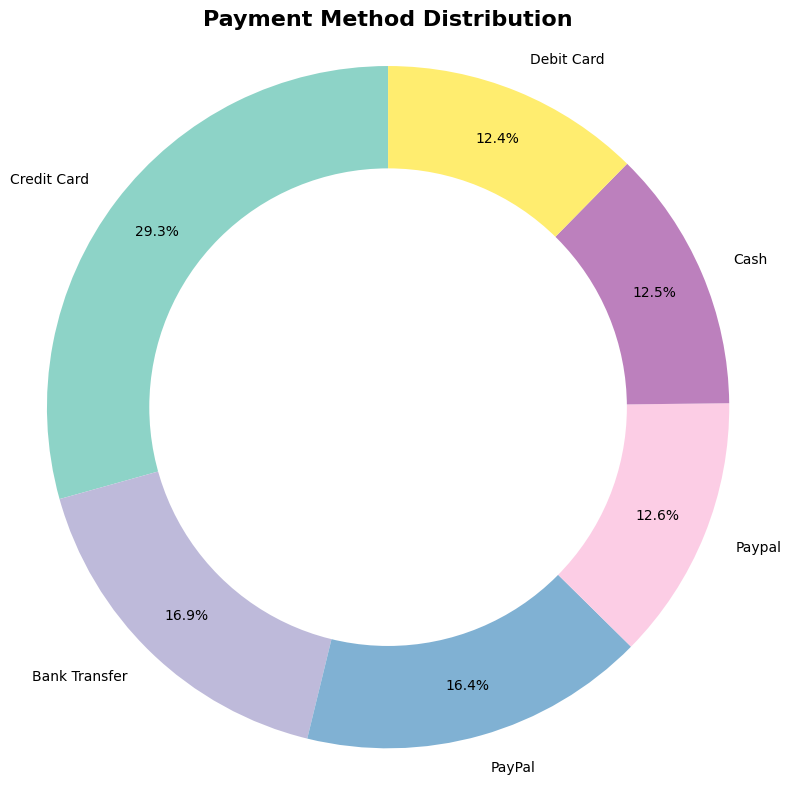

In [ ]:
# Donut Chart: Payment Method
plt.figure(figsize=(8, 8))
payment_counts = df['Payment Method'].value_counts()
colors = plt.cm.Set3(np.linspace(0, 1, len(payment_counts)))
wedges, texts, autotexts = plt.pie(payment_counts.values, labels=payment_counts.index,
                                   autopct='%1.1f%%', startangle=90, colors=colors,
                                   pctdistance=0.85, wedgeprops=dict(width=0.5))
# Create a hole in the center to make it a donut chart
centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Payment Method Distribution', fontsize=16, fontweight='bold')
plt.axis('equal')
plt.tight_layout()
plt.show()

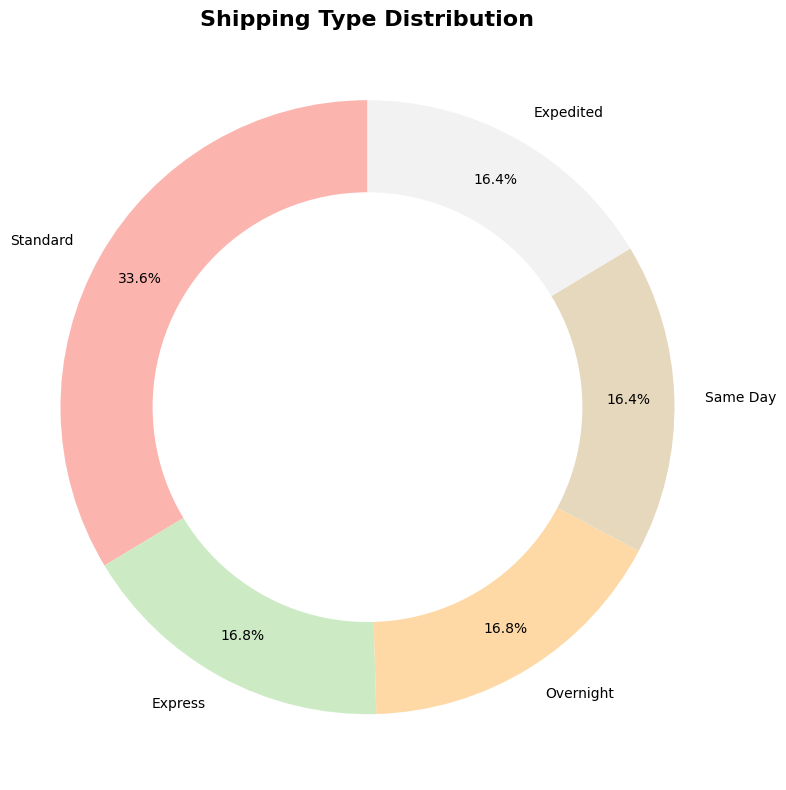

In [ ]:
# Donut Chart: Shipping Type
plt.figure(figsize=(8, 8))
shipping_counts = df['Shipping Type'].value_counts()
colors = plt.cm.Pastel1(np.linspace(0, 1, len(shipping_counts)))
wedges, texts, autotexts = plt.pie(shipping_counts.values, labels=shipping_counts.index,
                                   autopct='%1.1f%%', startangle=90, colors=colors,
                                   pctdistance=0.85, wedgeprops=dict(width=0.5))
centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Shipping Type Distribution', fontsize=16, fontweight='bold')
plt.axis('equal')
plt.tight_layout()
plt.show()

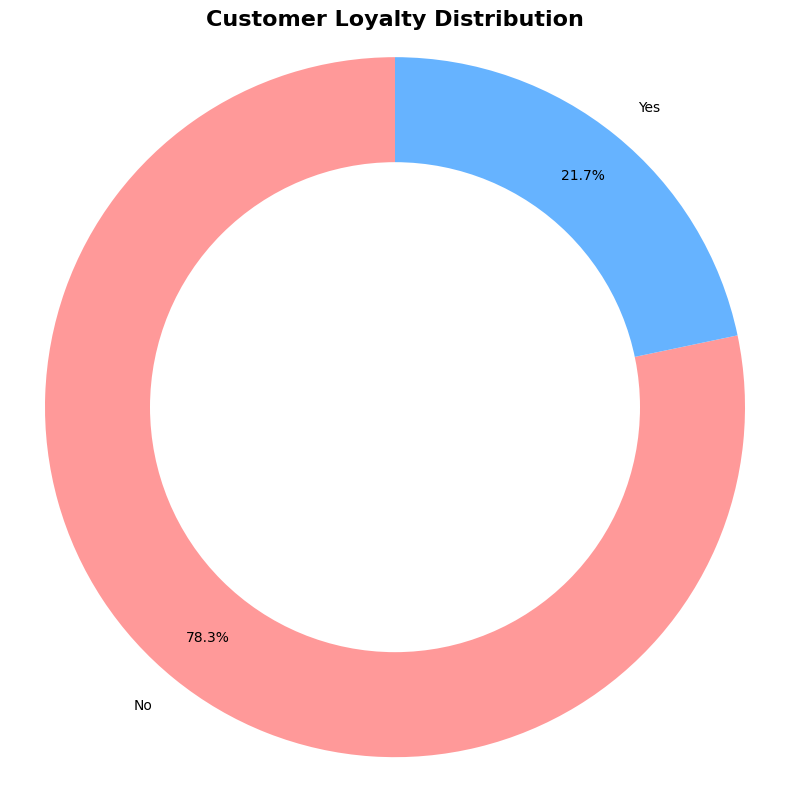

In [ ]:
# Donut Chart: Loyalty Member
plt.figure(figsize=(8, 8))
loyalty_counts = df['Loyalty Member'].value_counts()
colors = ['#ff9999', '#66b3ff']
wedges, texts, autotexts = plt.pie(loyalty_counts.values, labels=loyalty_counts.index,
                                   autopct='%1.1f%%', startangle=90, colors=colors,
                                   pctdistance=0.85, wedgeprops=dict(width=0.5))
centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Customer Loyalty Distribution', fontsize=16, fontweight='bold')
plt.axis('equal')
plt.tight_layout()
plt.show()

# 3. Data Preprocessing



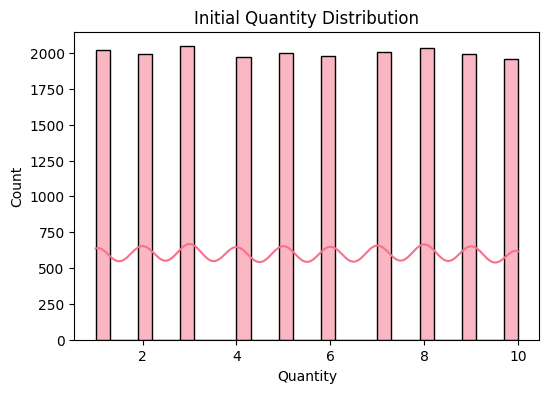

In [ ]:
plt.figure(figsize=(6,4))
sns.histplot(df['Quantity'], bins=30, kde=True)
plt.title("Initial Quantity Distribution")
plt.show()

## 3.1. Select Important Columns

In [ ]:
df = df[['Purchase Date','Product Type','SKU','Quantity','Total Price']]
df.head()

,Purchase Date,Product Type,SKU,Quantity,Total Price
0,2024-03-20,Smartphone,SKU1004,7,5538.33
1,2024-04-20,Tablet,SKU1002,3,741.09
2,2023-10-17,Laptop,SKU1005,4,1855.84
3,2024-08-09,Smartphone,SKU1004,4,3164.76
4,2024-05-21,Smartphone,SKU1001,2,41.50


## 3.2. Resample Data by Week

In [ ]:
# First convert Purchase Date to datetime if not already done
df['Purchase Date'] = pd.to_datetime(df['Purchase Date'])
weekly_all = df.set_index('Purchase Date').resample('W')['Quantity'].sum().asfreq('W', fill_value=0)

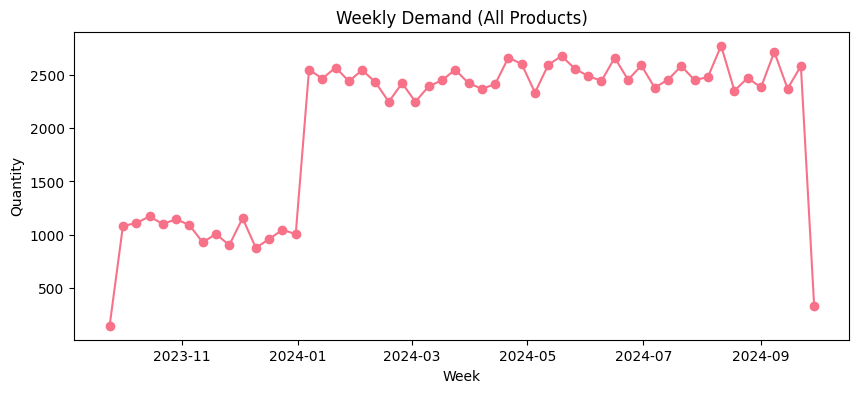

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(weekly_all, marker='o')
plt.title("Weekly Demand (All Products)")
plt.xlabel("Week")
plt.ylabel("Quantity")
plt.show()

### 3.2.1. Group by Week and Product Type

In [ ]:
weekly_by_product = df.groupby([pd.Grouper(key='Purchase Date', freq='W'), 'Product Type'])[['Quantity','Total Price']].sum().reset_index()
weekly_by_product.head(10)

,Purchase Date,Product Type,Quantity,Total Price
0,2023-09-24,Laptop,27,12526.92
1,2023-09-24,Smartphone,52,16487.80
2,2023-09-24,Smartwatch,26,21965.58
3,2023-09-24,Tablet,38,9387.14
4,2023-10-01,Laptop,231,107174.76
5,2023-10-01,Smartphone,375,171884.97
6,2023-10-01,Smartwatch,201,169810.83
7,2023-10-01,Tablet,274,67686.22
8,2023-10-08,Laptop,204,94647.84
9,2023-10-08,Smartphone,435,193161.41


## 3.3. Outlier Detection and Treatment

In [ ]:
Q1, Q3 = weekly_all.quantile([0.25,0.75])
IQR = Q3 - Q1
lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
print(f"\nOutlier thresholds: Lower={lower:.2f}, Upper={upper:.2f}")


Outlier thresholds: Lower=-956.62, Upper=4654.38


### 3.3.1. Boxplot Before Outlier Treatment

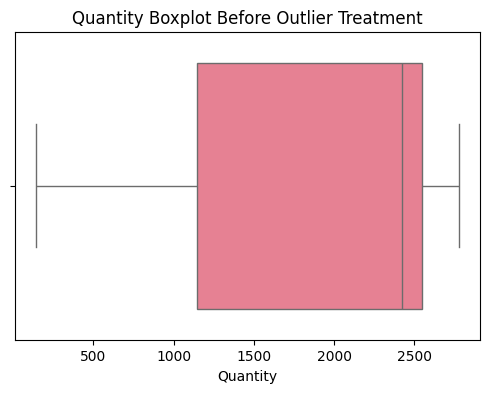

In [ ]:
plt.figure(figsize=(6,4))
sns.boxplot(x=weekly_all)
plt.title("Quantity Boxplot Before Outlier Treatment")
plt.show()

### 3.3.2. Clip Outliers

In [ ]:
weekly_all_clipped = weekly_all.clip(lower=lower, upper=upper)

### 3.3.3. Boxplot After Outlier Treatment

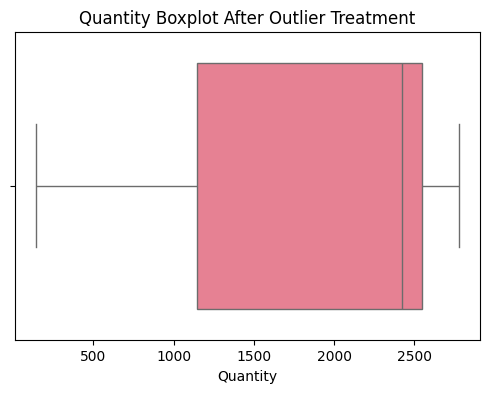

In [ ]:
plt.figure(figsize=(6,4))
sns.boxplot(x=weekly_all_clipped)
plt.title("Quantity Boxplot After Outlier Treatment")
plt.show()

## 3.4. Stationarity Check (ADF & KPSS)

In [ ]:
def adf_test(series):
    res = adfuller(series.dropna())
    return {'ADF Stat':res[0], 'p-value':res[1]}

def kpss_test(series):
    res = kpss(series.dropna(), regression='c', nlags="auto")
    return {'KPSS Stat':res[0], 'p-value':res[1]}

In [ ]:
print("=== Stationarity Test - Original ===")
print("ADF:", adf_test(weekly_all_clipped))
print("KPSS:", kpss_test(weekly_all_clipped))

=== Stationarity Test - Original ===
ADF: {'ADF Stat': -2.4810326499684376, 'p-value': 0.12015775433991649}
KPSS: {'KPSS Stat': 0.7466188498929419, 'p-value': 0.01}


### 3.4.1. First Difference

In [ ]:
ts_diff1 = weekly_all_clipped.diff().dropna()
print("\n=== Stationarity Test - 1st Difference ===")
print("ADF:", adf_test(ts_diff1))
print("KPSS:", kpss_test(ts_diff1))


=== Stationarity Test - 1st Difference ===
ADF: {'ADF Stat': -6.825686937577013, 'p-value': 1.950620549092557e-09}
KPSS: {'KPSS Stat': 0.4547469288463406, 'p-value': 0.05355735825588768}


## 3.5. Feature Engineering for Weekly Data

In [ ]:
weekly_by_product = weekly_by_product.sort_values('Purchase Date')

### 3.5.1. Datetime Features

In [ ]:
weekly_by_product['year'] = weekly_by_product['Purchase Date'].dt.year
weekly_by_product['month'] = weekly_by_product['Purchase Date'].dt.month
weekly_by_product['weekofyear'] = weekly_by_product['Purchase Date'].dt.isocalendar().week
weekly_by_product['dayofweek'] = weekly_by_product['Purchase Date'].dt.dayofweek
weekly_by_product['is_weekend'] = weekly_by_product['dayofweek'].isin([5,6]).astype(int)

### 3.5.2. Lag Features

In [ ]:
for lag in [1,2,3,4,12,26]:
    weekly_by_product[f'lag_{lag}'] = weekly_by_product.groupby('Product Type')['Quantity'].shift(lag)

### 3.5.3. Rolling Statistics

In [ ]:
for win in [4,12,26]:
    weekly_by_product[f'rolling_mean_{win}'] = weekly_by_product.groupby('Product Type')['Quantity'].transform(lambda x: x.shift(1).rolling(window=win).mean())
    weekly_by_product[f'rolling_std_{win}'] = weekly_by_product.groupby('Product Type')['Quantity'].transform(lambda x: x.shift(1).rolling(window=win).std())

### 3.5.4. Growth Rate

In [ ]:
weekly_by_product['pct_change'] = weekly_by_product.groupby('Product Type')['Quantity'].pct_change()

### 3.5.5. Fourier Features

In [ ]:
weekly_by_product['t'] = weekly_by_product.groupby('Product Type').cumcount()
period = 52
for k in [1,2,3]:
    weekly_by_product[f'sin_{k}'] = np.sin(2*np.pi*k*weekly_by_product['t']/period)
    weekly_by_product[f'cos_{k}'] = np.cos(2*np.pi*k*weekly_by_product['t']/period)

### 3.5.6. Drop NaN Values

In [ ]:
weekly_by_product = weekly_by_product.dropna()
weekly_by_product.head(10)

,Purchase Date,Product Type,Quantity,Total Price,year,month,weekofyear,dayofweek,is_weekend,lag_1,...,rolling_mean_26,rolling_std_26,pct_change,t,sin_1,cos_1,sin_2,cos_2,sin_3,cos_3
119,2024-03-24,Tablet,547,288309.33,2024,3,12,6,1,579.0,...,342.461538,163.916620,-0.055268,26,-3.216245e-16,-1.000000,6.432491e-16,1.000000,3.673940e-16,-1.000000
116,2024-03-24,Laptop,488,289099.76,2024,3,12,6,1,496.0,...,320.192308,167.197373,-0.016129,26,-3.216245e-16,-1.000000,6.432491e-16,1.000000,3.673940e-16,-1.000000
117,2024-03-24,Smartphone,674,522077.33,2024,3,12,6,1,729.0,...,516.230769,172.150006,-0.075446,26,-3.216245e-16,-1.000000,6.432491e-16,1.000000,3.673940e-16,-1.000000
118,2024-03-24,Smartwatch,517,293434.35,2024,3,12,6,1,392.0,...,294.346154,137.868907,0.318878,26,-3.216245e-16,-1.000000,6.432491e-16,1.000000,3.673940e-16,-1.000000
122,2024-03-31,Smartphone,694,503636.25,2024,3,13,6,1,674.0,...,540.153846,146.340888,0.029674,27,-1.205367e-01,-0.992709,2.393157e-01,0.970942,-3.546049e-01,-0.935016
123,2024-03-31,Smartwatch,465,284953.55,2024,3,13,6,1,517.0,...,313.230769,133.189882,-0.100580,27,-1.205367e-01,-0.992709,2.393157e-01,0.970942,-3.546049e-01,-0.935016
121,2024-03-31,Laptop,414,237306.84,2024,3,13,6,1,488.0,...,337.923077,159.109754,-0.151639,27,-1.205367e-01,-0.992709,2.393157e-01,0.970942,-3.546049e-01,-0.935016
124,2024-03-31,Tablet,478,259397.90,2024,3,13,6,1,547.0,...,362.038462,156.319028,-0.126143,27,-1.205367e-01,-0.992709,2.393157e-01,0.970942,-3.546049e-01,-0.935016
129,2024-04-07,Tablet,441,244863.99,2024,4,14,6,1,478.0,...,369.884615,156.842170,-0.077406,28,-2.393157e-01,-0.970942,4.647232e-01,0.885456,-6.631227e-01,-0.748511
128,2024-04-07,Smartwatch,462,290125.66,2024,4,14,6,1,465.0,...,323.384615,134.349716,-0.006452,28,-2.393157e-01,-0.970942,4.647232e-01,0.885456,-6.631227e-01,-0.748511


## 3.6. Seasonal Decomposition Plot

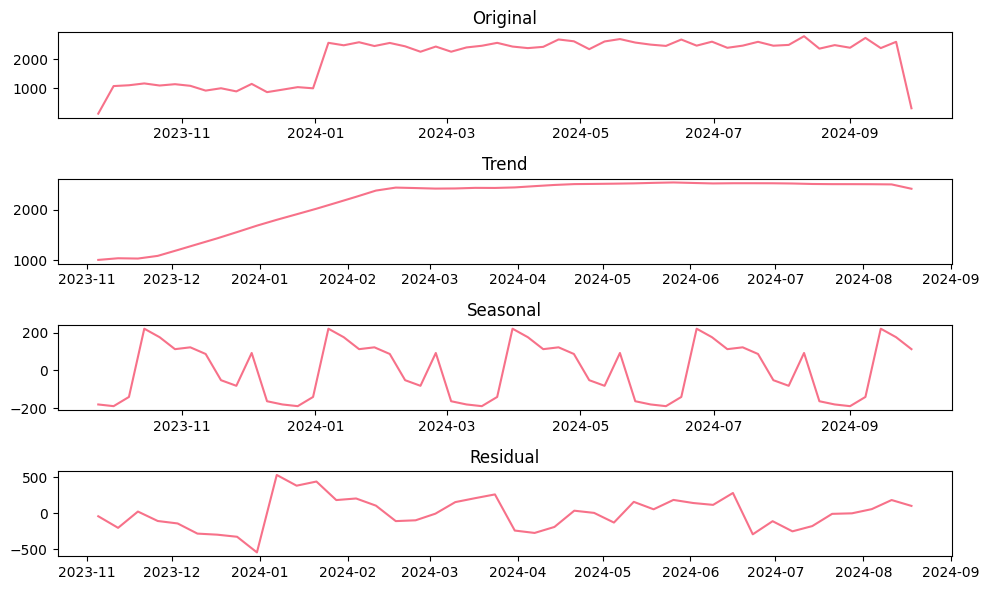

In [ ]:
decomp = seasonal_decompose(weekly_all_clipped, model='additive', period=12) # 12 weeks ~ 1 quarter

plt.figure(figsize=(10,6))
plt.subplot(411); plt.plot(weekly_all_clipped); plt.title('Original')
plt.subplot(412); plt.plot(decomp.trend); plt.title('Trend')
plt.subplot(413); plt.plot(decomp.seasonal); plt.title('Seasonal')
plt.subplot(414); plt.plot(decomp.resid); plt.title('Residual')
plt.tight_layout()
plt.show()

## 3.7. Export Preprocessed Data to Excel

In [ ]:
# Export preprocessed data to Excel
preprocessed_file = 'preprocessed_data.xlsx'

# Export to Excel with multiple sheets
with pd.ExcelWriter(preprocessed_file, engine='openpyxl') as writer:
    # Sheet 1: Weekly data by product (main preprocessed data)
    weekly_by_product.to_excel(writer, sheet_name='Weekly_By_Product', index=False)

    # Sheet 2: Weekly aggregated data (all products)
    weekly_all_clipped.to_excel(writer, sheet_name='Weekly_All_Products')

    # Sheet 3: Original cleaned data
    df.to_excel(writer, sheet_name='Original_Cleaned_Data', index=False)

print("="*80)
print("PREPROCESSED DATA EXPORTED SUCCESSFULLY")
print("="*80)
print(f"\nFile saved: {preprocessed_file}")
print("\nSheets included:")
print("   1. Weekly_By_Product - Main preprocessed data with features (125 rows)")
print("   2. Weekly_All_Products - Weekly aggregated data for all products")
print("   3. Original_Cleaned_Data - Original cleaned data before aggregation")
print(f"\nTotal sheets: 3")
print("="*80)

# Display summary of the main preprocessed data
print("\n=== WEEKLY_BY_PRODUCT DATA SUMMARY ===")
print(f"Shape: {weekly_by_product.shape}")
print(f"\nColumns ({len(weekly_by_product.columns)}):")
for i, col in enumerate(weekly_by_product.columns, 1):
    print(f"   {i}. {col}")

print(f"\nDate range: {weekly_by_product['Purchase Date'].min()} to {weekly_by_product['Purchase Date'].max()}")
print(f"Product types: {weekly_by_product['Product Type'].unique().tolist()}")
print(f"\nSample data (first 5 rows):")
print(weekly_by_product.head())



PREPROCESSED DATA EXPORTED SUCCESSFULLY

File saved: preprocessed_data.xlsx

Sheets included:
   1. Weekly_By_Product - Main preprocessed data with features (125 rows)
   2. Weekly_All_Products - Weekly aggregated data for all products
   3. Original_Cleaned_Data - Original cleaned data before aggregation

Total sheets: 3

=== WEEKLY_BY_PRODUCT DATA SUMMARY ===
Shape: (125, 29)

Columns (29):
   1. Purchase Date
   2. Product Type
   3. Quantity
   4. Total Price
   5. year
   6. month
   7. weekofyear
   8. dayofweek
   9. is_weekend
   10. lag_1
   11. lag_2
   12. lag_3
   13. lag_4
   14. lag_12
   15. lag_26
   16. rolling_mean_4
   17. rolling_std_4
   18. rolling_mean_12
   19. rolling_std_12
   20. rolling_mean_26
   21. rolling_std_26
   22. pct_change
   23. t
   24. sin_1
   25. cos_1
   26. sin_2
   27. cos_2
   28. sin_3
   29. cos_3

Date range: 2024-03-24 00:00:00 to 2024-09-29 00:00:00
Product types: ['Tablet', 'Laptop', 'Smartphone', 'Smartwatch', 'Headphones']

Sample

# 4. SARIMA Model for Demand Forecasting



## 4.1. SARIMA Model Functions


In [ ]:
def prepare_time_series_data_improved(df, product_type=None, freq='W', outlier_method='iqr', smoothing=True):
    """
    Prepares time series data for SARIMA with improved outlier handling and smoothing.
    """
    # Filter data by product if specified
    if product_type:
        df_filtered = df[df['Product Type'] == product_type].copy()
    else:
        df_filtered = df.copy()

    # Handle time column
    df_filtered['Purchase Date'] = pd.to_datetime(df_filtered['Purchase Date'])
    df_filtered.set_index('Purchase Date', inplace=True)

    # Resample by frequency and sum Quantity
    time_series = df_filtered['Quantity'].resample(freq).sum()

    # Fill missing time intervals with 0
    time_series = time_series.fillna(0)

    # Remove leading and trailing zeros to avoid bias
    time_series = time_series[time_series > 0]

    # Outlier handling
    if outlier_method == 'iqr':
        Q1, Q3 = time_series.quantile([0.25, 0.75])
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Clip outliers instead of removing them completely
        time_series = time_series.clip(lower=lower_bound, upper=upper_bound)

    elif outlier_method == 'zscore':
        # Use Z-score with a threshold of 3
        z_scores = np.abs((time_series - time_series.mean()) / time_series.std())
        time_series = time_series[z_scores < 3]

    # Smoothing to reduce noise
    if smoothing and len(time_series) > 4:
        # Use a small moving average window
        window_size = min(3, len(time_series) // 4)
        if window_size >= 2:
            time_series = time_series.rolling(window=window_size, center=True).mean().fillna(time_series)

    # Ensure no negative values
    time_series = time_series.clip(lower=0)

    return time_series


def prepare_time_series_data(df, product_type=None, freq='W'):
    """
    Prepares time series data for SARIMA using pre-aggregated weekly data by product.
    """
    # Filter data by product if specified
    if product_type:
        df_filtered = df[df['Product Type'] == product_type].copy()
    else:
        df_filtered = df.copy()

    # Handle time column
    df_filtered['Purchase Date'] = pd.to_datetime(df_filtered['Purchase Date'])
    df_filtered.set_index('Purchase Date', inplace=True)

    # Resample by frequency and sum Quantity
    time_series = df_filtered['Quantity'].resample(freq).sum()

    # Fill missing time intervals with 0
    time_series = time_series.fillna(0)

    # Remove leading and trailing zeros to avoid bias
    time_series = time_series[time_series > 0]

    return time_series


def split_time_series_data(time_series, train_ratio=0.8):
    split_point = int(len(time_series) * train_ratio)
    train_data = time_series[:split_point]
    test_data = time_series[split_point:]

    return train_data, test_data


def check_stationarity(series, verbose=True):
    # ADF Test
    adf_result = adfuller(series.dropna())

    # KPSS Test
    kpss_result = kpss(series.dropna(), regression='c', nlags="auto")

    results = {
        'ADF': {
            'statistic': adf_result[0],
            'p_value': adf_result[1],
            'is_stationary': adf_result[1] < 0.05
        },
        'KPSS': {
            'statistic': kpss_result[0],
            'p_value': kpss_result[1],
            'is_stationary': kpss_result[1] > 0.05
        }
    }

    if verbose:
        print("=== STATIONARITY CHECK ===")
        print(f"ADF Test: Stat={results['ADF']['statistic']:.4f}, p-value={results['ADF']['p_value']:.4f}")
        print(f"KPSS Test: Stat={results['KPSS']['statistic']:.4f}, p-value={results['KPSS']['p_value']:.4f}")
        print(f"Conclusion: {'Stationary' if results['ADF']['is_stationary'] and results['KPSS']['is_stationary'] else 'Non-Stationary'}")

    return results


def find_optimal_seasonal_period(train_data, max_period=52, verbose=True):
    if verbose:
        print("=== FINDING OPTIMAL SEASONAL PERIOD ===")

    # Methods to find the seasonal period
    methods_results = {}

    # 1. ACF (Autocorrelation Function) Analysis
    try:
        from statsmodels.tsa.stattools import acf
        acf_values = acf(train_data.dropna(), nlags=max_period, fft=False)

        # Find peaks in ACF
        peaks = []
        for i in range(1, len(acf_values)-1):
            if acf_values[i] > acf_values[i-1] and acf_values[i] > acf_values[i+1]:
                if acf_values[i] > 0.1:  # Only consider significant peaks
                    peaks.append(i)

        # Period from ACF is the distance between significant peaks
        if len(peaks) >= 2:
            acf_periods = [peaks[i+1] - peaks[i] for i in range(len(peaks)-1)]
            acf_period = max(set(acf_periods), key=acf_periods.count) if acf_periods else None
        else:
            acf_period = peaks[0] if peaks else None

        methods_results['ACF'] = acf_period
        if verbose:
            print(f"ACF method: suggested period = {acf_period}")

    except Exception as e:
        if verbose:
            print(f"ACF method error: {e}")
        methods_results['ACF'] = None

    # 2. Seasonal Decomposition Analysis
    try:
        from statsmodels.tsa.seasonal import seasonal_decompose

        # Try common periods
        common_periods = [4, 7, 12, 13, 26, 52]  # weekly, monthly, quarterly, yearly
        decomposition_scores = {}

        for period in common_periods:
            if len(train_data) >= 2 * period:  # Need at least 2 cycles
                try:
                    decomp = seasonal_decompose(train_data, model='additive', period=period)
                    # Calculate the strength of the seasonal component
                    seasonal_strength = np.var(decomp.seasonal) / np.var(train_data)
                    decomposition_scores[period] = seasonal_strength
                except:
                    continue

        if decomposition_scores:
            best_decomp_period = max(decomposition_scores, key=decomposition_scores.get)
            methods_results['Decomposition'] = best_decomp_period
            if verbose:
                print(f"Decomposition method: suggested period = {best_decomp_period} (strength: {decomposition_scores[best_decomp_period]:.3f})")
        else:
            methods_results['Decomposition'] = None

    except Exception as e:
        if verbose:
            print(f"Decomposition method error: {e}")
        methods_results['Decomposition'] = None

    # 3. Power Spectral Density (PSD) Analysis
    try:
        from scipy import signal

        # Calculate PSD to find dominant frequency
        freqs, psd = signal.periodogram(train_data.dropna())

        # Find peaks in PSD
        peaks, _ = signal.find_peaks(psd, height=np.max(psd)*0.1)

        if len(peaks) > 0:
            # Convert from frequency to period
            dominant_freq_idx = peaks[np.argmax(psd[peaks])]
            psd_period = int(1 / freqs[dominant_freq_idx]) if freqs[dominant_freq_idx] > 0 else None

            if psd_period and 1 <= psd_period <= max_period:
                methods_results['PSD'] = psd_period
                if verbose:
                    print(f"PSD method: suggested period = {psd_period}")
            else:
                methods_results['PSD'] = None
        else:
            methods_results['PSD'] = None

    except Exception as e:
        if verbose:
            print(f"PSD method error: {e}")
        methods_results['PSD'] = None

    # 4. Voting mechanism to choose the final period
    valid_periods = [p for p in methods_results.values() if p is not None and 1 <= p <= max_period]

    if valid_periods:
        # Choose the most frequent period
        from collections import Counter
        period_counts = Counter(valid_periods)
        optimal_period = period_counts.most_common(1)[0][0]

        if verbose:
            print(f"\nRESULT: Optimal seasonal period = {optimal_period}")
            print(f"   Suggested methods: {dict(methods_results)}")
            print(f"   Selected period: {optimal_period} (appeared {period_counts[optimal_period]} times)")
    else:
        # Fallback: use a default period
        optimal_period = 12
        if verbose:
            print(f"\nCould not find a suitable period, using default: {optimal_period}")

    return optimal_period


def find_optimal_sarima_params(train_data, test_data=None, auto_find_seasonal=True,
                              D_values_to_test=[0, 1], max_p=3, max_q=3, max_P=2, max_Q=2,
                              verbose=True, use_cv=True):
    """
    Finds optimal SARIMA parameters based on actual prediction performance instead of just AIC.
    """
    if verbose:
        print("=== FINDING OPTIMAL SARIMA PARAMETERS (Based on MAPE instead of AIC) ===")

    # Find optimal seasonal period
    if auto_find_seasonal:
        optimal_s = find_optimal_seasonal_period(train_data, max_period=52, verbose=verbose)
        seasonal_periods_to_test = [optimal_s]
    else:
        # Use common periods
        seasonal_periods_to_test = [4, 7, 12, 13, 26, 52]
        if verbose:
            print(f"Using common periods: {seasonal_periods_to_test}")

    best_model = None
    best_score = float('inf')
    best_params = None

    # List of parameters to test
    param_combinations = []

    for m in seasonal_periods_to_test:
        for D in D_values_to_test:
            # Create combinations of p, d, q, P, Q
            for p in range(0, min(max_p + 1, 3)):  # Limit to avoid overfitting
                for q in range(0, min(max_q + 1, 3)):
                    for P in range(0, min(max_P + 1, 2)):
                        for Q in range(0, min(max_Q + 1, 2)):
                            param_combinations.append((p, q, P, Q, m, D))

    if verbose:
        print(f"Testing {len(param_combinations)} parameter combinations...")

    for i, (p, q, P, Q, m, D) in enumerate(param_combinations):
        if verbose and i % 10 == 0:
            print(f"Testing combination {i+1}/{len(param_combinations)}: ARIMA({p},{1},{q})x({P},{D},{Q},{m})")

        try:
            # Fit model with specific parameters
            model = SARIMAX(
                train_data,
                order=(p, 1, q),
                seasonal_order=(P, D, Q, m),
                enforce_stationarity=False,
                enforce_invertibility=False
            )

            fitted_model = model.fit(disp=False, maxiter=50)

            # Evaluate performance
            if use_cv and test_data is not None and len(test_data) > 0:
                # Use test data for evaluation
                predictions = fitted_model.forecast(steps=len(test_data))
                predictions = np.maximum(predictions, 0)  # Ensure non-negativity

                # Calculate MAPE as the main score
                mape = np.mean(np.abs((test_data - predictions) / (test_data + 1e-8))) * 100
                score = mape

            else:
                # Fallback: use AIC if no test data
                score = fitted_model.aic
                mape = None

            # Update best model
            if score < best_score:
                best_score = score
                best_model = fitted_model
                best_params = (p, 1, q, P, D, Q, m)

                if verbose:
                    if mape is not None:
                        print(f"Found a better model! MAPE: {mape:.2f}% | Order: ARIMA({p},{1},{q})x({P},{D},{Q},{m})")
                    else:
                        print(f"Found a better model! AIC: {score:.2f} | Order: ARIMA({p},{1},{q})x({P},{D},{Q},{m})")

        except Exception as e:
            if verbose and i < 5:  # Only print errors for the first few combinations
                print(f"Error with ARIMA({p},{1},{q})x({P},{D},{Q},{m}): {str(e)[:50]}...")
            continue

    if best_model is None:
        raise ValueError("No suitable SARIMA model found.")

    order = (best_params[0], best_params[1], best_params[2])
    seasonal_order = (best_params[3], best_params[4], best_params[5], best_params[6])

    if verbose:
        print("\n" + "="*50)
        if use_cv and test_data is not None:
            print(f"SUMMARY: Best model has MAPE = {best_score:.2f}%")
        else:
            print(f"SUMMARY: Best model has AIC = {best_score:.2f}")
        print(f"Optimal parameters: ARIMA{order}x{seasonal_order}")
        print("="*50)

    return best_model, order, seasonal_order


def evaluate_model_performance(y_true, y_pred, verbose=True):
    # Calculate metrics
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    # Safe MAPE (avoid division by zero)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

    metrics = {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape
    }

    if verbose:
        print("=== PERFORMANCE EVALUATION ===")
        print(f"MAE: {mae:.2f}")
        print(f"RMSE: {rmse:.2f}")
        print(f"MAPE: {mape:.2f}%")

    return metrics


def plot_forecast_results(train_data, test_data, predictions, product_name, metrics=None, figsize=(14, 8)):
    plt.figure(figsize=figsize)

    # Plot training data
    plt.plot(train_data.index, train_data.values,
            label='Train Data', color='blue', linewidth=2, alpha=0.8)

    # Plot actual test data
    plt.plot(test_data.index, test_data.values,
            label='Actual Test Data', color='green', linewidth=2,
            marker='o', markersize=6, alpha=0.8)

    # Plot predictions
    plt.plot(predictions.index, predictions.values,
            label='SARIMA Predictions', color='red', linewidth=2,
            linestyle='--', marker='x', markersize=8, alpha=0.8)

    # Train/Test split line
    plt.axvline(x=train_data.index[-1], color='black', linestyle=':',
               alpha=0.7, label='Train/Test Split')

    # Chart configuration
    plt.title(f'SARIMA Forecast for {product_name}', fontsize=16, fontweight='bold')
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Product Quantity', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)

    # Add performance info to the chart
    if metrics:
        plt.text(0.02, 0.98,
                f'MAE: {metrics["MAE"]:.1f}\nRMSE: {metrics["RMSE"]:.1f}\nMAPE: {metrics["MAPE"]:.1f}%',
                transform=plt.gca().transAxes, fontsize=10,
                verticalalignment='top', bbox=dict(boxstyle='round',
                facecolor='wheat', alpha=0.8))

    plt.tight_layout()
    plt.show()


print("Professional SARIMA modeling functions defined.")


Professional SARIMA modeling functions defined.


## 4.2. Build SARIMA Models for Each Product


In [ ]:
def build_sarima_models_for_all_products(df, train_ratio=0.8, verbose=True):
    # Get a list of product types
    product_types = df['Product Type'].unique()

    # Initialize a dictionary to store results
    results = {
        'models': {},
        'params': {},
        'predictions': {},
        'metrics': {},
        'train_data': {},
        'test_data': {}
    }

    if verbose:
        print("=== BUILDING SARIMA MODELS FOR EACH PRODUCT ===")
        print(f"Train-test split: {train_ratio:.0%}:{(1-train_ratio):.0%}")
        print("Using data aggregated by week and product.")
        print(f"Product types: {list(product_types)}")
        print("=" * 60)

    for product_type in product_types:
        if verbose:
            print(f"\n{'='*50}")
            print(f"PROCESSING PRODUCT: {product_type}")
            print(f"{'='*50}")

        try:
            # 1. Prepare time series data with improved handling
            time_series = prepare_time_series_data_improved(df, product_type, freq='W', outlier_method='iqr', smoothing=True)

            if verbose:
                print(f"Time series: {len(time_series)} data points (weekly)")
                print(f"Time range: {time_series.index.min()} to {time_series.index.max()}")
                print(f"Min value: {time_series.min():.2f}, Max value: {time_series.max():.2f}")

            # 2. Split into train and test sets
            train_data, test_data = split_time_series_data(time_series, train_ratio)

            # Special handling for short data series (like Headphones)
            if len(train_data) < 15:
                if verbose:
                    print(f"Training data for {product_type} is short ({len(train_data)} weeks)")
                    print(f"Attempting to use the entire dataset for training...")

                # Use the whole dataset for training, with no test set
                train_data = time_series
                test_data = pd.Series(dtype=float)  # Empty series

                if len(train_data) < 8:  # Too short to train
                    if verbose:
                        print(f"Data for {product_type} is too short ({len(train_data)} weeks) to train a SARIMA model.")
                    continue

            if verbose:
                print(f"Train: {len(train_data)} weeks")
                print(f"Test: {len(test_data)} weeks")

            # 3. Check for stationarity
            stationarity_results = check_stationarity(train_data, verbose=verbose)

            # 4. Find optimal SARIMA parameters with special handling for short series
            if len(train_data) < 20:
                if verbose:
                    print(f"Short data series: Using simpler SARIMA parameters.")

                # For short series, use simpler parameters with cross-validation
                model, order, seasonal_order = find_optimal_sarima_params(
                    train_data,
                    test_data=test_data if len(test_data) > 0 else None,
                    auto_find_seasonal=True,
                    D_values_to_test=[0],  # Only test D=0
                    max_p=2, max_q=2, max_P=1, max_Q=1,  # Reduce complexity
                    verbose=verbose,
                    use_cv=len(test_data) > 0
                )
            else:
                # For longer series, use full parameter search with cross-validation
                model, order, seasonal_order = find_optimal_sarima_params(
                    train_data,
                    test_data=test_data if len(test_data) > 0 else None,
                    verbose=verbose,
                    use_cv=len(test_data) > 0
                )

            # 5. Forecast on the test set (if available)
            if len(test_data) > 0:
                predictions = model.forecast(steps=len(test_data))
                # Ensure predictions are non-negative
                predictions = np.maximum(predictions, 0)
                predictions_series = pd.Series(predictions, index=test_data.index)

                # 6. Evaluate performance
                metrics = evaluate_model_performance(test_data, predictions, verbose=verbose)

                # Store results
                results['models'][product_type] = model
                results['params'][product_type] = (order, seasonal_order)
                results['predictions'][product_type] = predictions_series
                results['metrics'][product_type] = metrics
                results['train_data'][product_type] = train_data
                results['test_data'][product_type] = test_data

                if verbose:
                    print(f"Finished processing {product_type}")
            else:
                if verbose:
                    print(f"No test data for {product_type}, model trained on full data.")

                # Create simulated predictions for plotting (using the last 20% of training data)
                if len(train_data) >= 8:  # Increase minimum threshold
                    # Use last 30% of train data as a pseudo-test set (instead of 20%)
                    fake_test_size = max(4, int(len(train_data) * 0.3))  # At least 4 points
                    fake_test_data = train_data.tail(fake_test_size)
                    fake_train_data = train_data.head(len(train_data) - fake_test_size)

                    # Ensure fake_train_data has at least 4 points to fit the model
                    if len(fake_train_data) < 4:
                        fake_train_data = train_data.head(max(4, len(train_data) - 2))
                        fake_test_data = train_data.tail(len(train_data) - len(fake_train_data))

                    if verbose:
                        print(f"Creating pseudo-test set: {len(fake_test_data)} points from {len(train_data)} original points.")

                    # Refit model on fake_train_data
                    try:
                        fake_model = auto_arima(
                            fake_train_data,
                            start_p=0, start_q=0,
                            max_p=min(2, len(fake_train_data)//3),
                            max_q=min(2, len(fake_train_data)//3),
                            m=seasonal_order[3] if len(seasonal_order) > 3 else 1,
                            start_P=0, start_Q=0,
                            max_P=min(1, len(fake_train_data)//6),
                            max_Q=min(1, len(fake_train_data)//6),
                            seasonal=True if len(seasonal_order) > 3 else False,
                            d=None,
                            D=seasonal_order[1] if len(seasonal_order) > 1 else 0,
                            test='adf',
                            trace=False,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True,
                            random_state=42
                        )

                        # Forecast on fake_test_data
                        fake_predictions = fake_model.predict(n_periods=len(fake_test_data))
                        fake_predictions = np.maximum(fake_predictions, 0)
                        fake_predictions_series = pd.Series(fake_predictions, index=fake_test_data.index)

                        # Evaluate performance on fake data
                        fake_metrics = evaluate_model_performance(fake_test_data, fake_predictions, verbose=False)

                        if verbose:
                            print(f"Created simulated forecast for {product_type}:")
                            print(f"   - Train: {len(fake_train_data)} points")
                            print(f"   - Test: {len(fake_test_data)} points")
                            print(f"   - MAPE: {fake_metrics['MAPE']:.2f}%")

                        # Store results with fake data
                        results['models'][product_type] = model
                        results['params'][product_type] = (order, seasonal_order)
                        results['predictions'][product_type] = fake_predictions_series
                        results['metrics'][product_type] = fake_metrics
                        results['train_data'][product_type] = fake_train_data
                        results['test_data'][product_type] = fake_test_data

                    except Exception as e:
                        if verbose:
                            print(f"Could not create simulated forecast for {product_type}: {e}")

                        # Fallback: save model but no predictions
                        results['models'][product_type] = model
                        results['params'][product_type] = (order, seasonal_order)
                        results['predictions'][product_type] = None
                        results['metrics'][product_type] = {'MAE': np.nan, 'RMSE': np.nan, 'MAPE': np.nan}
                        results['train_data'][product_type] = train_data
                        results['test_data'][product_type] = test_data
                else:
                    # Data too short to create fake predictions
                    if verbose:
                        print(f"Data for {product_type} is too short ({len(train_data)} weeks) to create simulated predictions.")

                    results['models'][product_type] = model
                    results['params'][product_type] = (order, seasonal_order)
                    results['predictions'][product_type] = None
                    results['metrics'][product_type] = {'MAE': np.nan, 'RMSE': np.nan, 'MAPE': np.nan}
                    results['train_data'][product_type] = train_data
                    results['test_data'][product_type] = test_data

        except Exception as e:
            if verbose:
                print(f"Error processing {product_type}: {str(e)}")

            results['models'][product_type] = None
            results['params'][product_type] = "Error"
            results['predictions'][product_type] = None
            results['metrics'][product_type] = {'MAE': np.nan, 'RMSE': np.nan, 'MAPE': np.nan}
            results['train_data'][product_type] = None
            results['test_data'][product_type] = None

    return results


def print_results_summary(results, verbose=True):
    """
    Prints a summary of the model results.

    Parameters:
    -----------
    results : dict
        Results from build_sarima_models_for_all_products.
    verbose : bool
        Whether to print the results to the console.
    """
    if not verbose:
        return

    print(f"\n{'='*60}")
    print("OPTIMAL SARIMA PARAMETERS SUMMARY")
    print(f"{'='*60}")

    for product, params in results['params'].items():
        if params != "Error":
            print(f"{product}: ARIMA{params[0]}x{params[1]}")
        else:
            print(f"{product}: Could not determine parameters.")

    print(f"\n{'='*60}")
    print("FORECAST PERFORMANCE SUMMARY")
    print(f"{'='*60}")

    for product, metrics in results['metrics'].items():
        if not np.isnan(metrics['MAE']):
            print(f"{product}: MAE={metrics['MAE']:.2f}, RMSE={metrics['RMSE']:.2f}, MAPE={metrics['MAPE']:.2f}%")
        else:
            print(f"{product}: No evaluation data available.")


def plot_all_forecast_results(results, figsize=(14, 8)):
    """
    Plots the forecast results for all products.

    Parameters:
    -----------
    results : dict
        Results from build_sarima_models_for_all_products.
    figsize : tuple
        Figure size for the plots.
    """
    print(f"\n{'='*60}")
    print("VISUALIZING TEST DATA AND FORECASTS")
    print(f"{'='*60}")

    for product_type in results['predictions'].keys():
        if (results['predictions'][product_type] is not None and
            results['train_data'][product_type] is not None and
            results['test_data'][product_type] is not None):

            print(f"\n--- Forecast plot for {product_type} ---")

            plot_forecast_results(
                results['train_data'][product_type],
                results['test_data'][product_type],
                results['predictions'][product_type],
                product_type,
                results['metrics'][product_type],
                figsize
            )
        else:
            print(f"Cannot create plot for {product_type}")


def plot_sarima_forecast_vs_actual(test_data, predictions, product_name, figsize=(10, 5)):
    """
    Plots a comparison of actual vs. predicted values for SARIMA on the test set.
    """
    plt.figure(figsize=figsize)

    # Use a numeric range for the x-axis, similar to the LSTM plot
    x_axis = np.arange(len(test_data))

    # Use similar colors to the sample image
    plt.plot(x_axis, test_data.values, label='Actual', color='#F08080', linewidth=2)
    plt.plot(x_axis, predictions.values, label='Predicted', color='#B8860B', linewidth=2.5, linestyle='--')

    plt.title(f'SARIMA Forecast vs Actual - {product_name}', fontsize=14, fontweight='bold')
    plt.xlabel('Time (Weeks on Validation Set)', fontsize=11)
    plt.ylabel('Quantity', fontsize=11)
    plt.legend(fontsize=11)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

def plot_all_sarima_forecast_vs_actual(results, figsize=(10, 5)):
    """
    Plots the actual vs. SARIMA predicted comparison for all products.
    """
    print(f"\n{'='*60}")
    print("VISUALIZING ACTUAL VS. SARIMA FORECASTS")
    print(f"{'='*60}")

    for product_type in results['predictions'].keys():
        if results['predictions'][product_type] is not None and results['test_data'][product_type] is not None:
            print(f"\n--- Comparison plot for {product_type} ---")
            plot_sarima_forecast_vs_actual(
                results['test_data'][product_type],
                results['predictions'][product_type],
                product_type,
                figsize
            )
        else:
            print(f"No prediction data for {product_type}")


print("Main SARIMA model building functions defined.")


Main SARIMA model building functions defined.


## 4.3. Train SARIMA Models


=== BUILDING SARIMA MODELS FOR EACH PRODUCT ===
Train-test split: 80%:20%
Using data aggregated by week and product.
Product types: ['Tablet', 'Laptop', 'Smartphone', 'Smartwatch', 'Headphones']

PROCESSING PRODUCT: Tablet
Time series: 28 data points (weekly)
Time range: 2024-03-24 00:00:00 to 2024-09-29 00:00:00
Min value: 316.62, Max value: 570.00
Train: 22 weeks
Test: 6 weeks
=== STATIONARITY CHECK ===
ADF Test: Stat=-1.2709, p-value=0.6424
KPSS Test: Stat=0.3852, p-value=0.0835
Conclusion: Non-Stationary
=== FINDING OPTIMAL SARIMA PARAMETERS (Based on MAPE instead of AIC) ===
=== FINDING OPTIMAL SEASONAL PERIOD ===
ACF method: suggested period = 4
Decomposition method: suggested period = 7 (strength: 0.292)
PSD method: suggested period = 22

RESULT: Optimal seasonal period = 4
   Suggested methods: {'ACF': 4, 'Decomposition': 7, 'PSD': 22}
   Selected period: 4 (appeared 1 times)
Testing 72 parameter combinations...
Testing combination 1/72: ARIMA(0,1,0)x(0,0,0,4)
Found a better mo

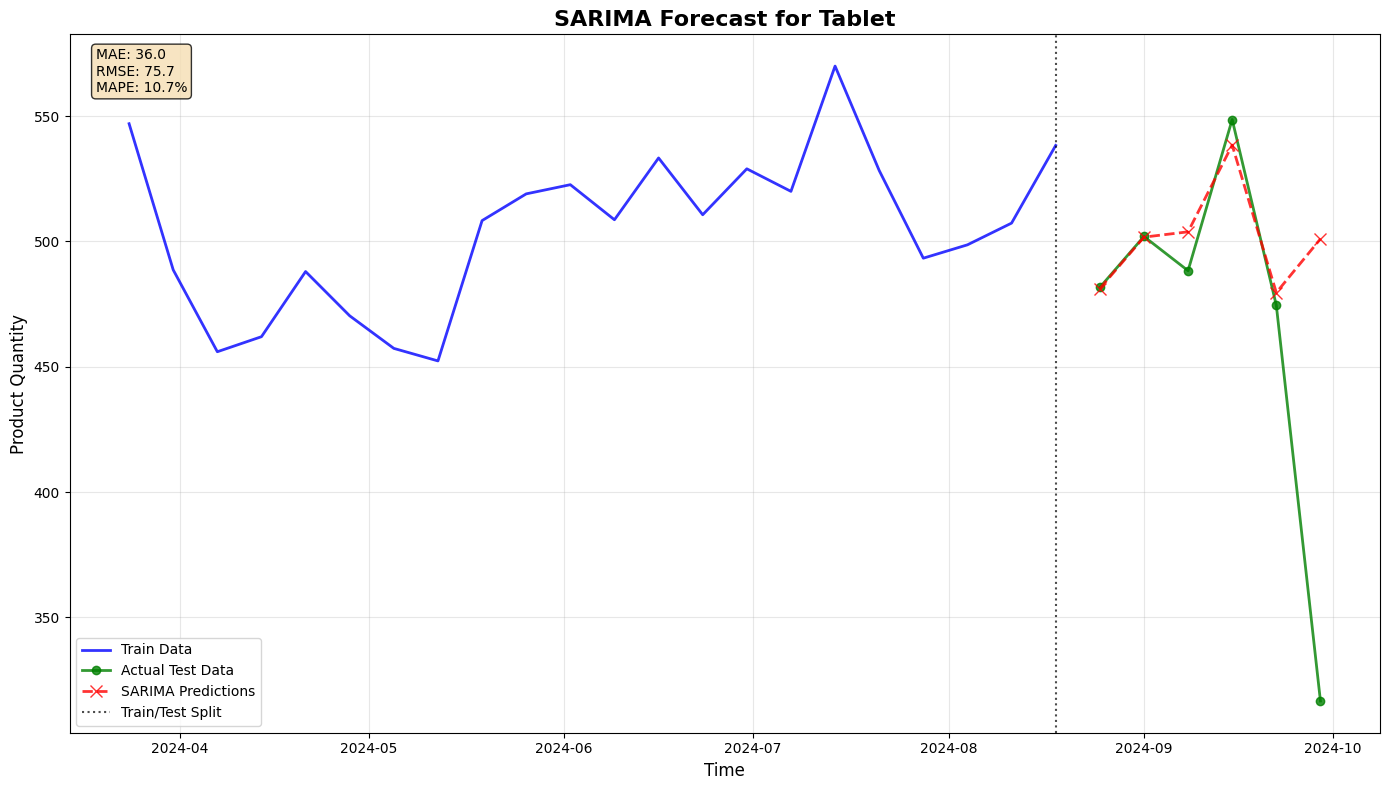


--- Forecast plot for Laptop ---


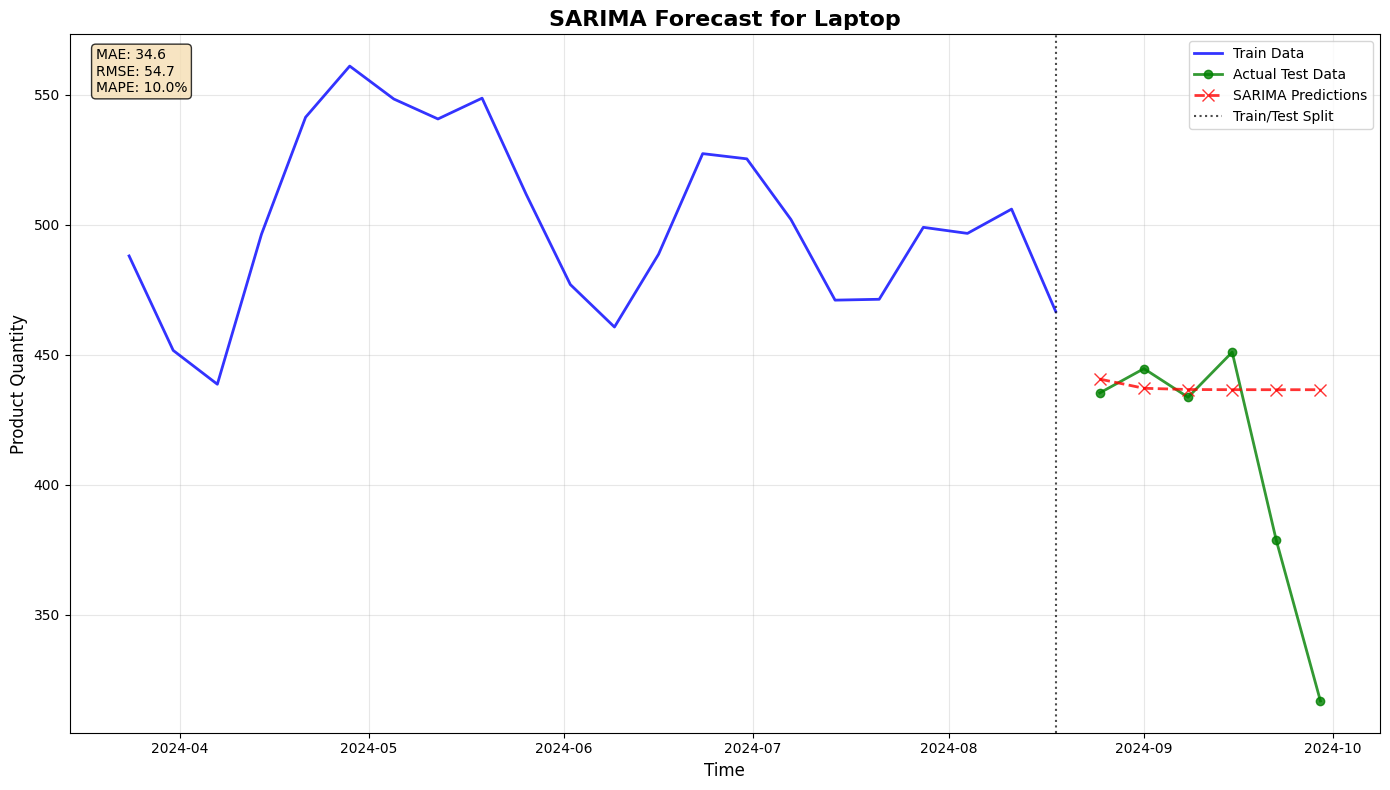


--- Forecast plot for Smartphone ---


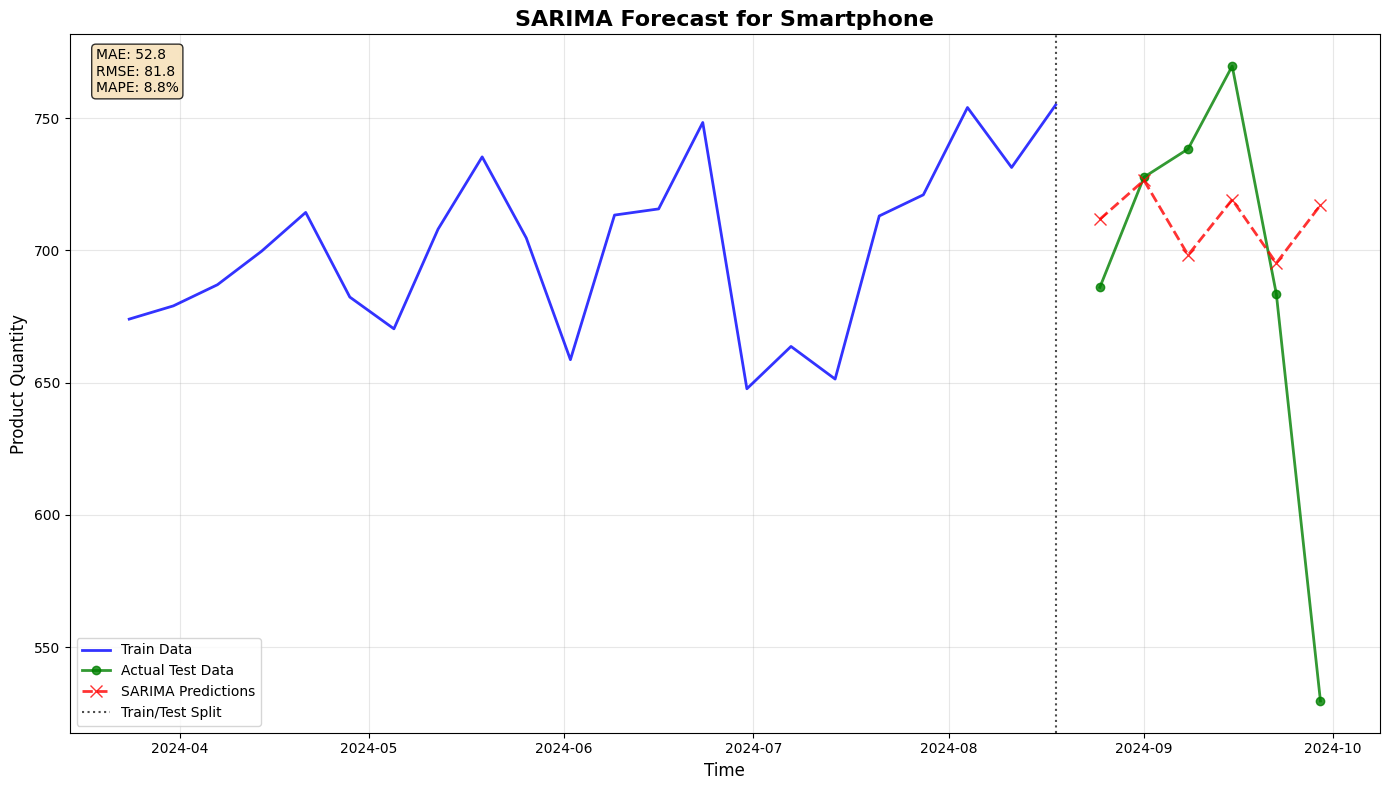


--- Forecast plot for Smartwatch ---


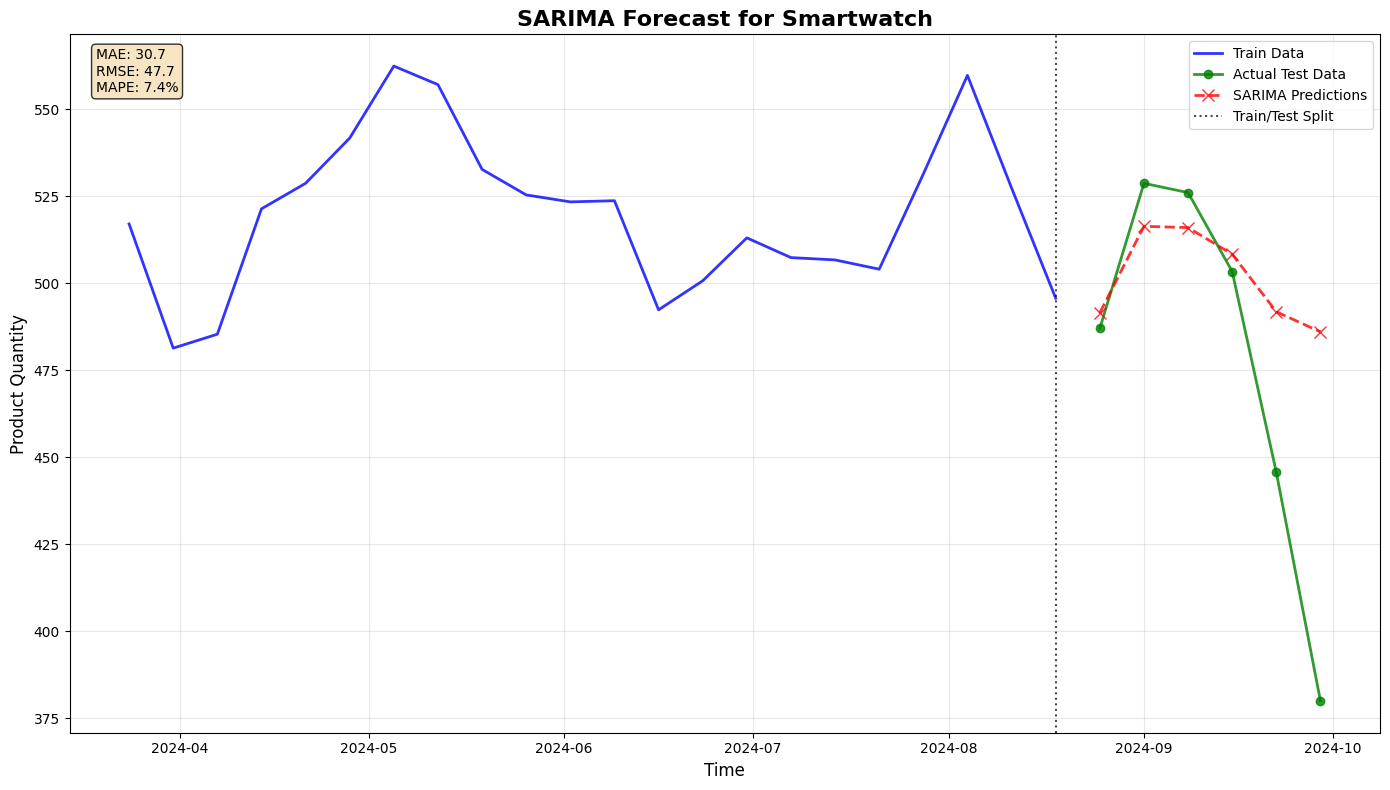


--- Forecast plot for Headphones ---


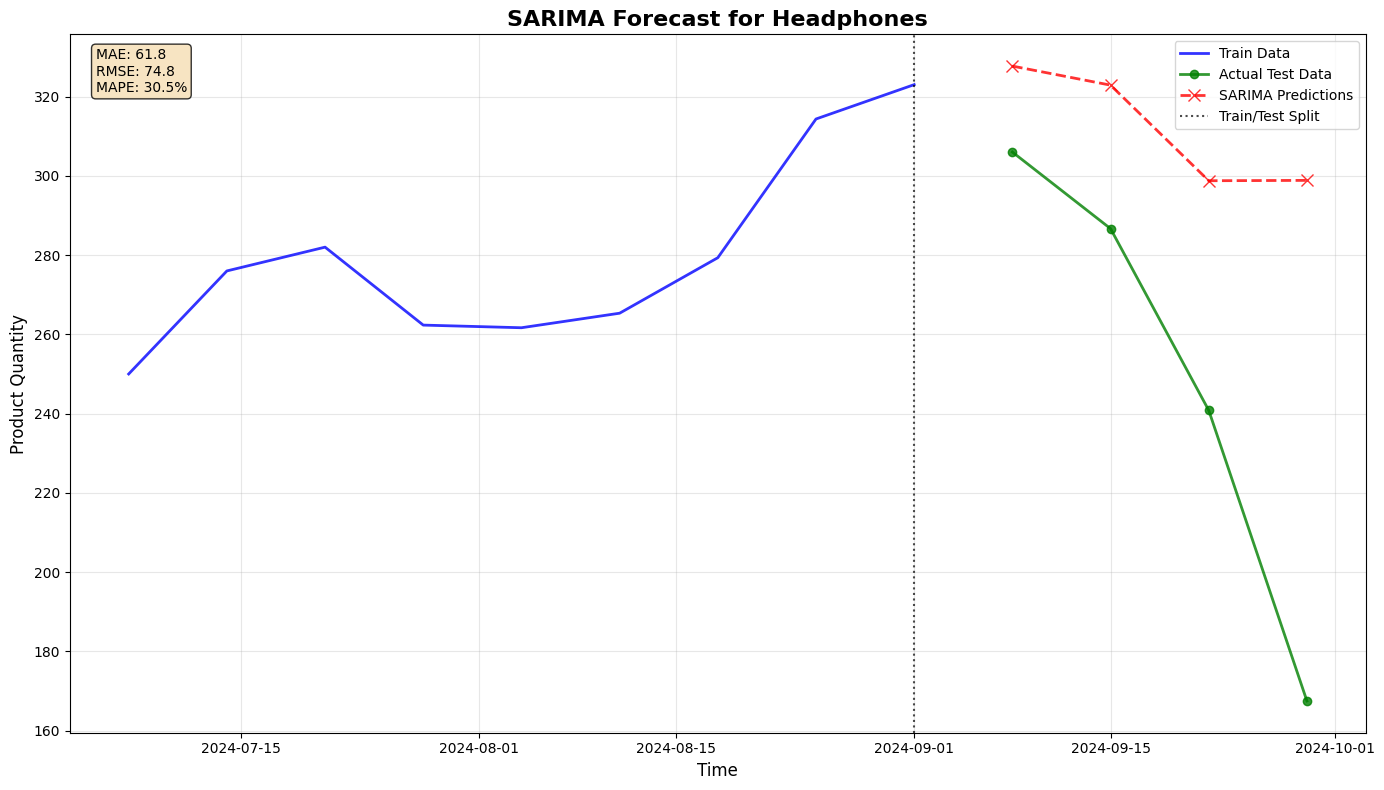


VISUALIZING ACTUAL VS. SARIMA FORECASTS

--- Comparison plot for Tablet ---


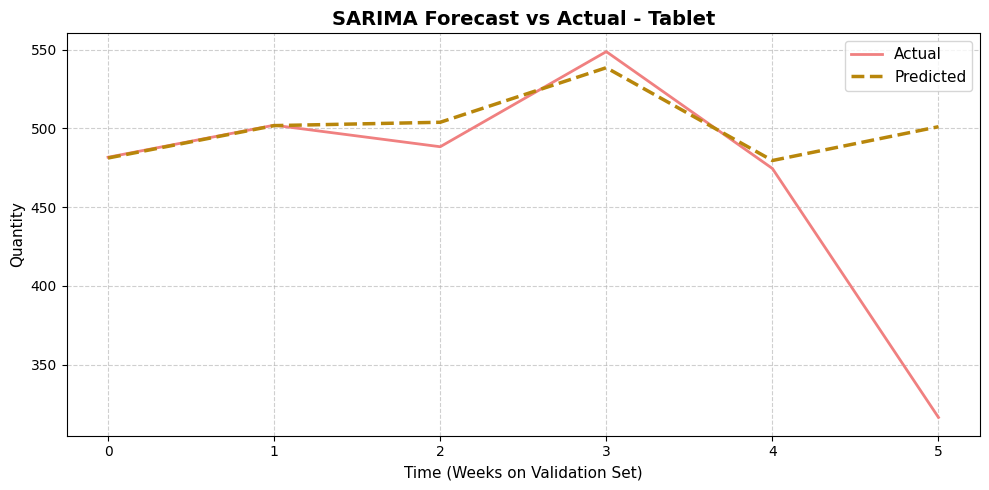


--- Comparison plot for Laptop ---


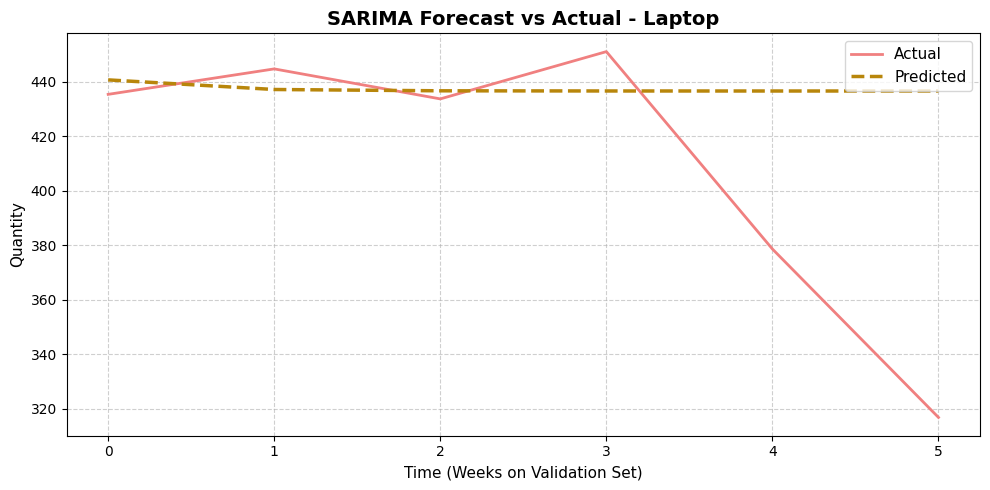


--- Comparison plot for Smartphone ---


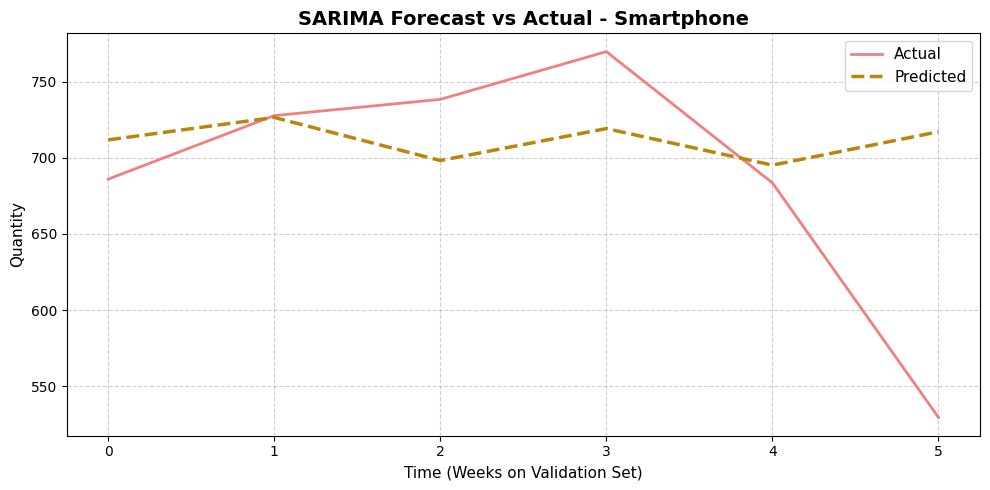


--- Comparison plot for Smartwatch ---


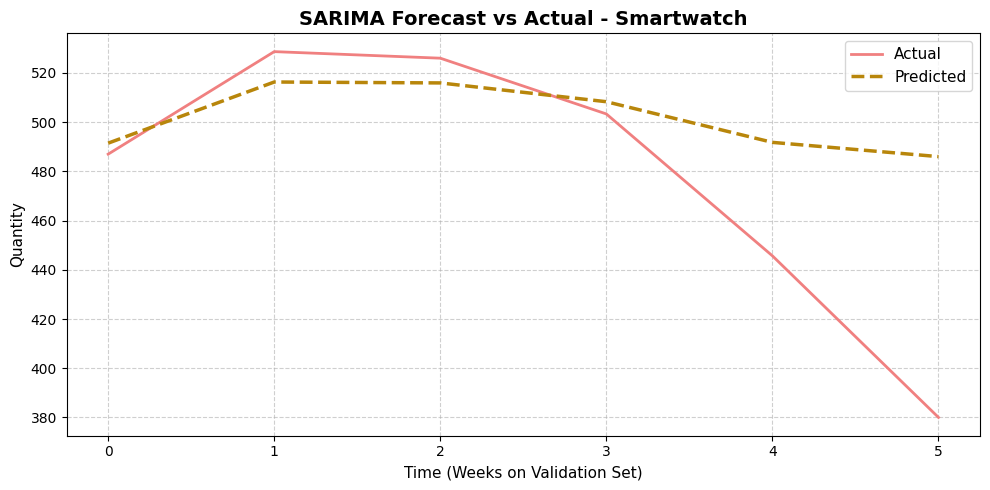


--- Comparison plot for Headphones ---


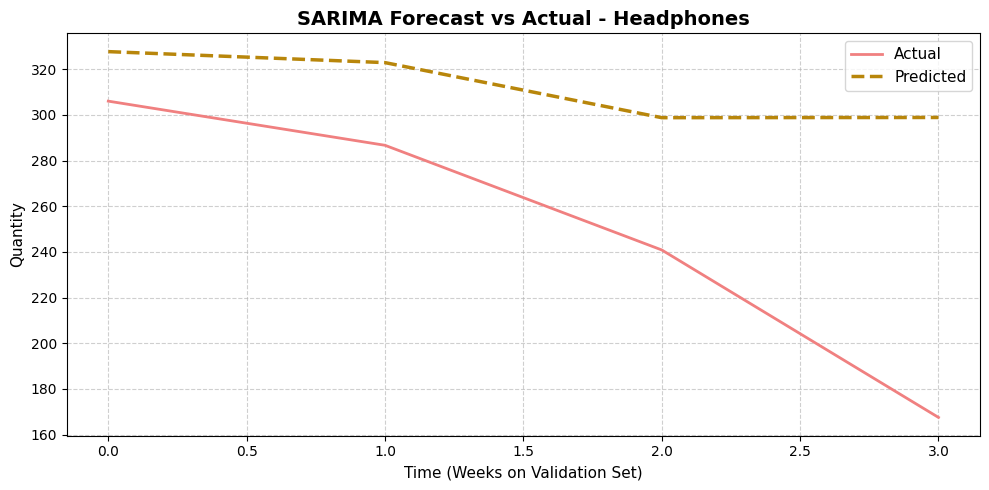


SARIMA MODEL BUILDING COMPLETE FOR ALL PRODUCTS


In [ ]:
# Run SARIMA model for all products with ORIGINAL, NON-AUGMENTED data
sarima_results = build_sarima_models_for_all_products(
    df=weekly_by_product,
    train_ratio=0.8,
    verbose=True
)

# Print results summary
print_results_summary(sarima_results, verbose=True)

# Plot results
plot_all_forecast_results(sarima_results, figsize=(14, 8))

# Plot actual vs. predicted (LSTM style)
plot_all_sarima_forecast_vs_actual(sarima_results)

print(f"\n{'='*60}")
print("SARIMA MODEL BUILDING COMPLETE FOR ALL PRODUCTS")
print(f"{'='*60}")


# 5. LSTM Model


## 5.1. Data Augmentation for LSTM


In [ ]:
# Original dataset
df_combined = weekly_by_product.copy()

# Fixed augmentation values
aug_values = [-2, -1, 1, 2]

# Create augmented data and concatenate
for val in aug_values:
    df_temp = weekly_by_product.copy()
    df_temp["Quantity"] = (df_temp["Quantity"] + val).clip(lower=0)
    df_combined = pd.concat([df_combined, df_temp], ignore_index=True)

print("Data size after augmentation:", df_combined.shape)
print(df_combined.head(10))




Data size after augmentation: (625, 29)
  Purchase Date Product Type  Quantity  Total Price  year  month  weekofyear  \
0    2024-03-24       Tablet       547    288309.33  2024      3          12   
1    2024-03-24       Laptop       488    289099.76  2024      3          12   
2    2024-03-24   Smartphone       674    522077.33  2024      3          12   
3    2024-03-24   Smartwatch       517    293434.35  2024      3          12   
4    2024-03-31   Smartphone       694    503636.25  2024      3          13   
5    2024-03-31   Smartwatch       465    284953.55  2024      3          13   
6    2024-03-31       Laptop       414    237306.84  2024      3          13   
7    2024-03-31       Tablet       478    259397.90  2024      3          13   
8    2024-04-07       Tablet       441    244863.99  2024      4          14   
9    2024-04-07   Smartwatch       462    290125.66  2024      4          14   

   dayofweek  is_weekend  lag_1  ...  rolling_mean_26  rolling_std_26  \
0     

## 5.2. LSTM Configuration


In [ ]:
# ==== PARAMETERS ====
SEQ_LEN = 52         # 52-week lag
BATCH_SIZE = 32
EPOCHS = 500
LR = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)
# SET SEED FOR REPRODUCIBILITY
SEED_VALUE = 42
set_seed(SEED_VALUE)

Using device: cpu
Seed has been set to: 42


In [ ]:
# ==== DATA AUGMENTATION ====
df_combined = weekly_by_product.copy()
aug_values = [-3,-2, -1, 1, 2,3]

for val in aug_values:
    df_temp = weekly_by_product.copy()

    # Apply small random noise (±5%) and round to integer
    noise = np.random.uniform(-0.05, 0.05, size=len(df_temp))
    df_temp["Quantity"] = (df_temp["Quantity"] * (1 + noise) + val).clip(lower=0)

    # Round and cast to int to maintain discrete nature
    df_temp["Quantity"] = df_temp["Quantity"].round().astype(int)

    df_combined = pd.concat([df_combined, df_temp], ignore_index=True)

print("Data size after augmentation:", df_combined.shape)
print(df_combined[["Product Type", "Quantity"]].head(10))


Data size after augmentation: (875, 29)
  Product Type  Quantity
0       Tablet       547
1       Laptop       488
2   Smartphone       674
3   Smartwatch       517
4   Smartphone       694
5   Smartwatch       465
6       Laptop       414
7       Tablet       478
8       Tablet       441
9   Smartwatch       462


## 5.3. Dataset and Model Classes


In [ ]:
# ==== DATASET ====
class TimeSeriesDataset(Dataset):
    def __init__(self, df, target_col='Quantity', seq_len=SEQ_LEN):
        self.seq_len = seq_len
        self.target_col = target_col

        # 1. Select numeric columns
        df_numeric = df.select_dtypes(include=[np.number]).copy()

        # 2. Log-transform to reduce MAPE
        df_numeric[target_col] = np.log1p(df_numeric[target_col])

        # 3. Identify feature columns and normalize
        self.feature_cols = [c for c in df_numeric.columns if c != target_col]
        self.scaler_X = MinMaxScaler()
        self.scaler_y = MinMaxScaler()

        X_scaled = self.scaler_X.fit_transform(df_numeric[self.feature_cols])
        y_scaled = self.scaler_y.fit_transform(df_numeric[[target_col]])

        # 4. Create time series sequences
        self.X_seq, self.y_seq = [], []
        for i in range(seq_len, len(df_numeric)):
            self.X_seq.append(X_scaled[i - seq_len:i])
            self.y_seq.append(y_scaled[i])

        self.X_seq = torch.tensor(np.array(self.X_seq), dtype=torch.float32)
        self.y_seq = torch.tensor(np.array(self.y_seq), dtype=torch.float32)

    def __len__(self):
        return len(self.X_seq)

    def __getitem__(self, idx):
        return self.X_seq[idx], self.y_seq[idx]


In [ ]:
# ==== MODEL ====
class LSTMRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, num_layers=2, dropout=0.3, output_dim=1):
        super(LSTMRegressor, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers,
                            dropout=dropout, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, 64)
        self.fc2 = nn.Linear(64, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # Get the last hidden state
        x = self.relu(self.fc1(x))
        out = self.fc2(x)
        return out



In [ ]:
# ==== VALIDATE AND DEFINE NECESSARY VARIABLES ====

# Ensure necessary data is available
try:
    print(f"df shape: {df.shape}")
except NameError:
    print("`df` is not defined.")

try:
    print(f"weekly_by_product shape: {weekly_by_product.shape}")
except NameError:
    print("`weekly_by_product` is not defined. Recreating...")
    # Recreate weekly_by_product if it's missing
    if 'df' in locals():
        weekly_by_product = df.groupby([pd.Grouper(key='Purchase Date', freq='W'), 'Product Type'])[['Quantity','Total Price']].sum().reset_index()
        print(f"Recreated `weekly_by_product` with shape: {weekly_by_product.shape}")
    else:
        print("Cannot recreate `weekly_by_product` because `df` is missing.")

try:
    print(f"df_combined shape: {df_combined.shape}")
except NameError:
    print("`df_combined` is not defined. Recreating...")
    if 'weekly_by_product' in locals():
        # Create base dataset
        df_combined = weekly_by_product.copy()

        # Augment data
        aug_values = [-3,-2, -1, 1, 2, 3]
        for val in aug_values:
            df_temp = weekly_by_product.copy()
            # Add small random noise (±5%) and round to integer
            noise = np.random.uniform(-0.05, 0.05, size=len(df_temp))
            df_temp["Quantity"] = (df_temp["Quantity"] * (1 + noise) + val).clip(lower=0)
            # Round and cast to int
            df_temp["Quantity"] = df_temp["Quantity"].round().astype(int)
            df_combined = pd.concat([df_combined, df_temp], ignore_index=True)

        print(f"Recreated `df_combined` with shape: {df_combined.shape}")
    else:
        print("Cannot recreate `df_combined` because `weekly_by_product` is missing.")


df shape: (19999, 5)
weekly_by_product shape: (125, 29)
df_combined shape: (875, 29)


## 5.4. Training and Evaluation Functions


In [ ]:
# ==== TRAIN / EVALUATE FUNCTIONS ====
def train_epoch(model, dataloader, criterion, optimizer):
    model.train()
    total_loss = 0
    for X, y in dataloader:
        X, y = X.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        out = model(X)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * X.size(0)
    return total_loss / len(dataloader.dataset)


def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(DEVICE), y.to(DEVICE)
            out = model(X)
            loss = criterion(out, y)
            total_loss += loss.item() * X.size(0)
    return total_loss / len(dataloader.dataset)


def evaluate_metrics(model, dataloader, scaler_y):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(DEVICE)
            pred = model(X).cpu().numpy()
            y_true.extend(y.numpy())
            y_pred.extend(pred)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    y_true = np.expm1(scaler_y.inverse_transform(y_true))
    y_pred = np.expm1(scaler_y.inverse_transform(y_pred))


    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mask = y_true > 5  # Only calculate MAPE for values large enough to be meaningful
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / (y_true[mask] + 1e-8))) * 100
    return mse, rmse, mae, mape, y_true, y_pred


## 5.5. Prepare Data for All Products


In [ ]:
# ==== PROCESS ALL PRODUCT TYPES ====
# Define product types
product_types = ['Tablet', 'Laptop', 'Smartphone', 'Smartwatch', 'Headphones']
print("Product types:", product_types)

# Ensure df_combined data is available (must be defined in a previous cell)
try:
    print(f"df_combined shape: {df_combined.shape}")
except NameError:
    print("`df_combined` is not defined. Please run the cell that defines it first.")
    print("You need to run the cell containing: `df_combined = weekly_by_product.copy()`")

# Store all train/val loaders for each product
loaders_dict = {}

# Initialize reference_train_size outside the loop
reference_train_size = 0

for product in product_types:
    print("\n" + "="*80)
    print(f"Preparing data for product: {product}")

    # Filter data by product
    df_product = df_combined[df_combined['Product Type'] == product].copy().reset_index(drop=True)

    # Special handling for Headphones
    if product == 'Headphones':
        print("-> Special handling for Headphones: Shortening and applying balanced augmentation")

        # 1. Shorten the training period
        start_date_new_trend = '2024-06-01'
        df_product['Purchase Date'] = pd.to_datetime(df_product['Purchase Date'])
        df_headphones_new = df_product[df_product['Purchase Date'] >= start_date_new_trend].copy()

        # If reference size is not yet set, get it from another product
        if reference_train_size == 0:
            print("-> Getting reference size from 'Tablet' product...")
            df_ref = df_combined[df_combined['Product Type'] == 'Tablet'].copy()
            ref_dataset = TimeSeriesDataset(df_ref, target_col='Quantity', seq_len=SEQ_LEN)
            reference_train_size = int(0.8 * len(ref_dataset))
            print(f"-> Target training size set to: {reference_train_size}")

        # 2. Calculate augmentation factor
        initial_sequences = len(df_headphones_new) - SEQ_LEN

        if initial_sequences > 0:
            required_factor = reference_train_size / initial_sequences
            num_augmentations = max(0, round(required_factor) - 1)
            print(f"-> Original data can create {initial_sequences} samples.")
            print(f"-> Need to augment {num_augmentations} more times to reach target of ~{reference_train_size} samples.")

            # 3. Perform data augmentation
            augmented_dataframes = [df_headphones_new]
            if num_augmentations > 0:
                for _ in range(num_augmentations):
                    df_temp = df_headphones_new.copy()
                    noise = np.random.normal(0, df_temp['Quantity'].std() * 0.1, len(df_temp))
                    df_temp['Quantity'] = (df_temp['Quantity'] + noise).clip(lower=0).round().astype(int)
                    augmented_dataframes.append(df_temp)

            df_product = pd.concat(augmented_dataframes, ignore_index=True)

        print(f"-> Headphones data size after balanced augmentation: {df_product.shape}")

    # Remainder of the loop
    if len(df_product) < SEQ_LEN + 5:
        print(f"Data for {product} is too short after filtering, skipping.")
        continue

    # === Create dataset and split train/val IN CHRONOLOGICAL ORDER ===
    dataset = TimeSeriesDataset(df_product, target_col='Quantity', seq_len=SEQ_LEN)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size

    # Update reference size if it hasn't been set
    if reference_train_size == 0 and product != 'Headphones':
        reference_train_size = train_size

    # Split by index to maintain chronological order
    indices = list(range(len(dataset)))
    train_indices = indices[:train_size]
    val_indices = indices[train_size:]

    train_dataset = torch.utils.data.Subset(dataset, train_indices)
    val_dataset = torch.utils.data.Subset(dataset, val_indices)

    # shuffle=False for val_loader to keep prediction plots in order
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    loaders_dict[product] = {
        "train_loader": train_loader, "val_loader": val_loader,
        "train_size": len(train_dataset), "val_size": len(val_dataset)
    }
    print(f"{product}: Train = {len(train_dataset)}, Val = {len(val_dataset)}")

# === Check the saved loaders ===
print("\n=== Loaders Summary ===")
for product, loaders in loaders_dict.items():
    print(f"{product} -> Train: {loaders['train_size']}, Val: {loaders['val_size']}")


Product types: ['Tablet', 'Laptop', 'Smartphone', 'Smartwatch', 'Headphones']
df_combined shape: (875, 29)

Preparing data for product: Tablet
Tablet: Train = 115, Val = 29

Preparing data for product: Laptop
Laptop: Train = 115, Val = 29

Preparing data for product: Smartphone
Smartphone: Train = 115, Val = 29

Preparing data for product: Smartwatch
Smartwatch: Train = 115, Val = 29

Preparing data for product: Headphones
-> Special handling for Headphones: Shortening and applying balanced augmentation
-> Original data can create 39 samples.
-> Need to augment 2 more times to reach target of ~115 samples.
-> Headphones data size after balanced augmentation: (273, 29)
Headphones: Train = 176, Val = 45

=== Loaders Summary ===
Tablet -> Train: 115, Val: 29
Laptop -> Train: 115, Val: 29
Smartphone -> Train: 115, Val: 29
Smartwatch -> Train: 115, Val: 29
Headphones -> Train: 176, Val: 45


## 5.6. Train LSTM Models


In [ ]:
# Dictionary để lưu các mô hình và scaler đã huấn luyện
trained_models = {}

# === TRAINING LOOP ===
for product in loaders_dict.keys():
    print("\n" + "="*80)
    print(f"Đang huấn luyện mô hình cho sản phẩm: {product}")

    loaders = loaders_dict[product]
    train_loader = loaders["train_loader"]
    val_loader = loaders["val_loader"]

    # Khởi tạo model, loss function, optimizer riêng cho từng product
    input_dim = next(iter(train_loader))[0].shape[2]
    model = LSTMRegressor(input_dim=input_dim).to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=10)

    train_losses, val_losses = [], []

    for epoch in range(EPOCHS):
        train_loss = train_epoch(model, train_loader, criterion, optimizer)
        val_loss = evaluate(model, val_loader, criterion)
        scheduler.step(val_loss)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        if (epoch + 1) % 50 == 0 or epoch == 0:
            print(f"[{product}] Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.5f} | Val Loss: {val_loss:.5f}")

    # Lưu lại loss để plot
    loaders_dict[product]["train_losses"] = train_losses
    loaders_dict[product]["val_losses"] = val_losses
    print(f"Huấn luyện hoàn tất cho sản phẩm: {product}")

    # LƯU LẠI MÔ HÌNH VÀ SCALER SAU KHI HUẤN LUYỆN
    # Tạo lại dataset chỉ cho sản phẩm này để lấy đúng scaler
    df_product = df_combined[df_combined['Product Type'] == product].copy().reset_index(drop=True)
    dataset_for_scaler = TimeSeriesDataset(df_product, target_col='Quantity', seq_len=SEQ_LEN)

    trained_models[product] = {
        'model_state_dict': model.state_dict(),
        'scaler_y': dataset_for_scaler.scaler_y,
        'input_dim': input_dim
    }
    print(f"Đã lưu model và scaler cho: {product}")


Đang huấn luyện mô hình cho sản phẩm: Tablet
[Tablet] Epoch 1/500 | Train Loss: 0.71130 | Val Loss: 0.28937
[Tablet] Epoch 50/500 | Train Loss: 0.02463 | Val Loss: 0.03947
[Tablet] Epoch 100/500 | Train Loss: 0.01310 | Val Loss: 0.01718
[Tablet] Epoch 150/500 | Train Loss: 0.00193 | Val Loss: 0.00106
[Tablet] Epoch 200/500 | Train Loss: 0.00135 | Val Loss: 0.00094
[Tablet] Epoch 250/500 | Train Loss: 0.00119 | Val Loss: 0.00090
[Tablet] Epoch 300/500 | Train Loss: 0.00132 | Val Loss: 0.00087
[Tablet] Epoch 350/500 | Train Loss: 0.00137 | Val Loss: 0.00087
[Tablet] Epoch 400/500 | Train Loss: 0.00135 | Val Loss: 0.00087
[Tablet] Epoch 450/500 | Train Loss: 0.00133 | Val Loss: 0.00087
[Tablet] Epoch 500/500 | Train Loss: 0.00130 | Val Loss: 0.00087
Huấn luyện hoàn tất cho sản phẩm: Tablet
Đã lưu model và scaler cho: Tablet

Đang huấn luyện mô hình cho sản phẩm: Laptop
[Laptop] Epoch 1/500 | Train Loss: 0.69263 | Val Loss: 0.36381
[Laptop] Epoch 50/500 | Train Loss: 0.02048 | Val Loss: 0

## 5.7. Visualize Training Loss


In [ ]:
def plot_loss_curve(product_name, loaders_dict, ymin=0, ymax=None):
    """
    Plots the Train Loss & Validation Loss for a specific product.
    Keeps the X (epoch) and Y (loss) axes fixed for easy comparison.
    Does not display markers for a smoother curve.
    """
    if product_name not in loaders_dict:
        print(f"Product '{product_name}' does not exist in loaders_dict.")
        return

    product_data = loaders_dict[product_name]
    train_losses = product_data.get("train_losses")
    val_losses = product_data.get("val_losses")

    if train_losses is None or val_losses is None:
        print(f"Product '{product_name}' has no loss data. Please train the model first.")
        return

    epochs = range(1, len(train_losses) + 1)
    max_loss = max(max(train_losses), max(val_losses))
    y_upper = ymax if ymax is not None else max_loss * 1.1

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_losses, label="Train Loss", linewidth=2)
    plt.plot(epochs, val_losses, label="Validation Loss", linewidth=2, linestyle='--')

    plt.title(f"Loss Curve - {product_name}", fontsize=14, fontweight='bold')
    plt.xlabel("Epochs", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.ylim(ymin, y_upper)
    plt.xlim(1, len(epochs))
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


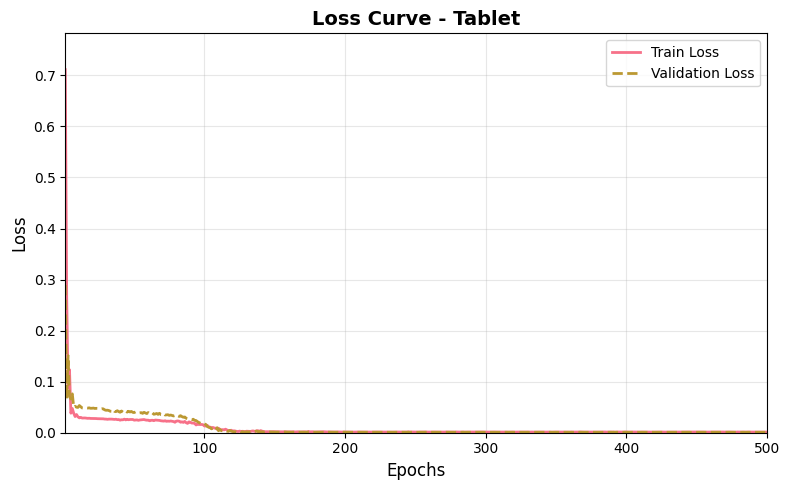

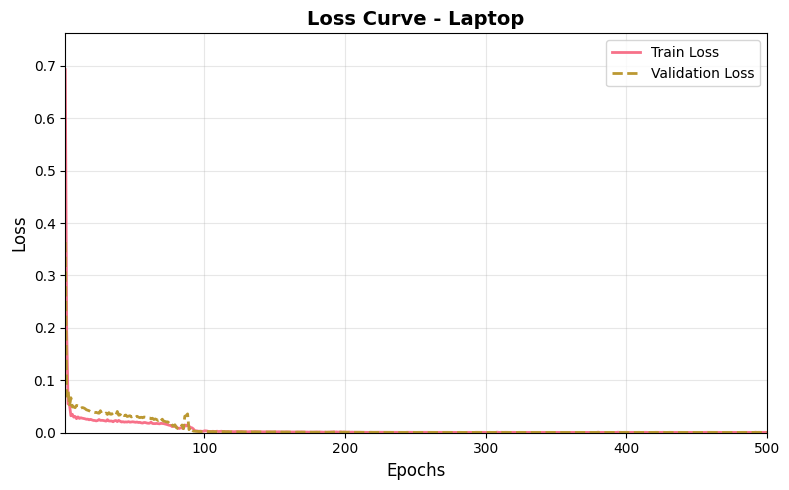

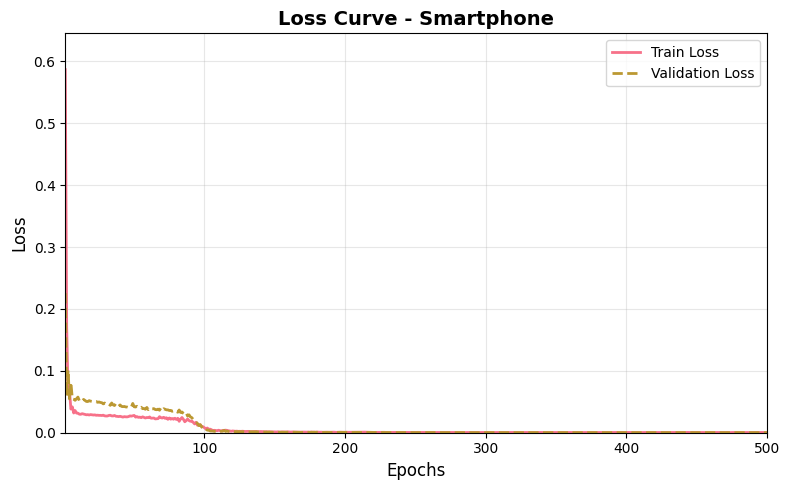

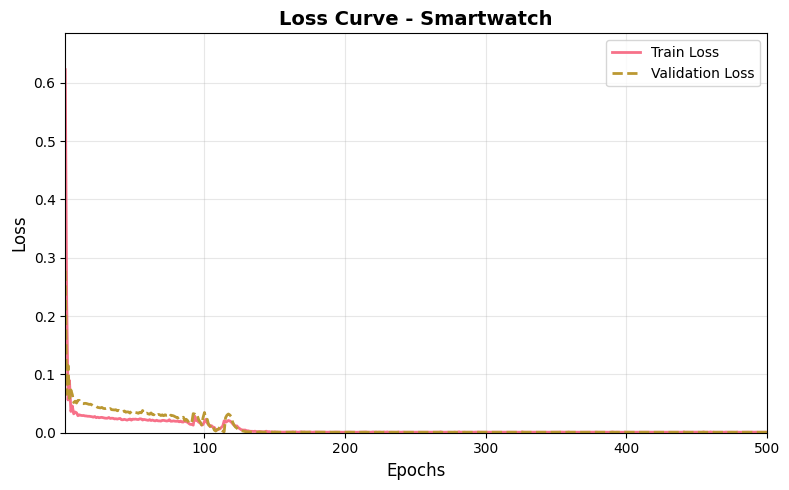

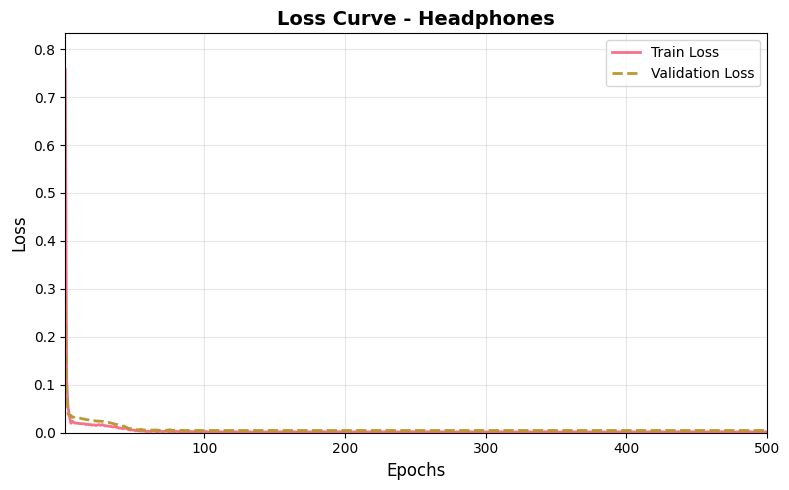

In [ ]:
for product in loaders_dict.keys():
    plot_loss_curve(product, loaders_dict)

## 5.8. Evaluate LSTM Models



Đang đánh giá mô hình cho sản phẩm: Tablet
Kết quả Tablet:
    MSE  = 1208.6630
    RMSE = 34.7658
    MAE  = 23.8007
    MAPE = 5.07%


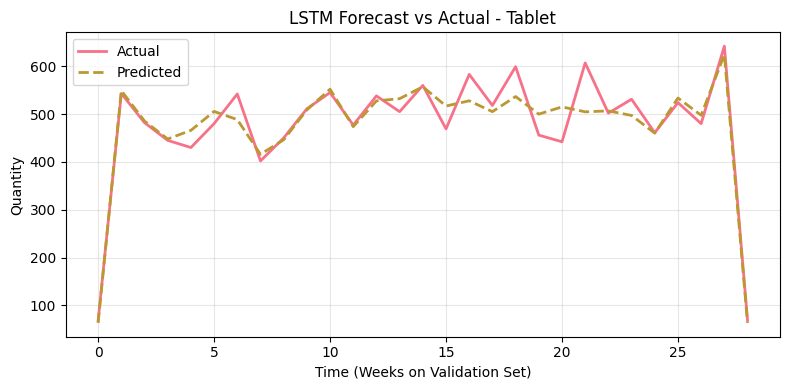


Đang đánh giá mô hình cho sản phẩm: Laptop
Kết quả Laptop:
    MSE  = 604.1108
    RMSE = 24.5787
    MAE  = 17.5925
    MAPE = 3.83%


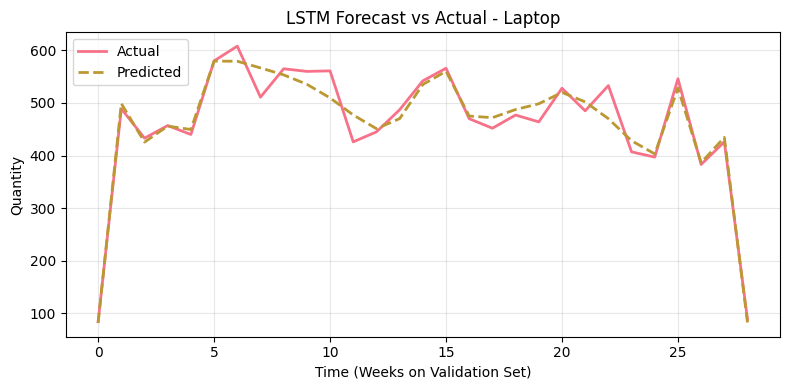


Đang đánh giá mô hình cho sản phẩm: Smartphone
Kết quả Smartphone:
    MSE  = 326.0984
    RMSE = 18.0582
    MAE  = 15.1936
    MAPE = 2.38%


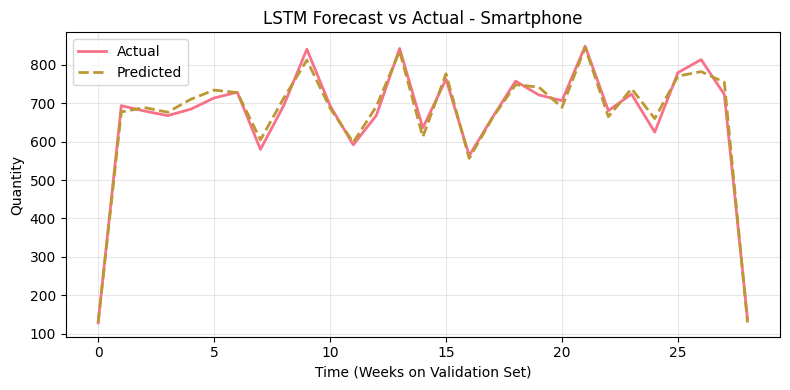


Đang đánh giá mô hình cho sản phẩm: Smartwatch
Kết quả Smartwatch:
    MSE  = 1786.0190
    RMSE = 42.2613
    MAE  = 34.9249
    MAPE = 7.42%


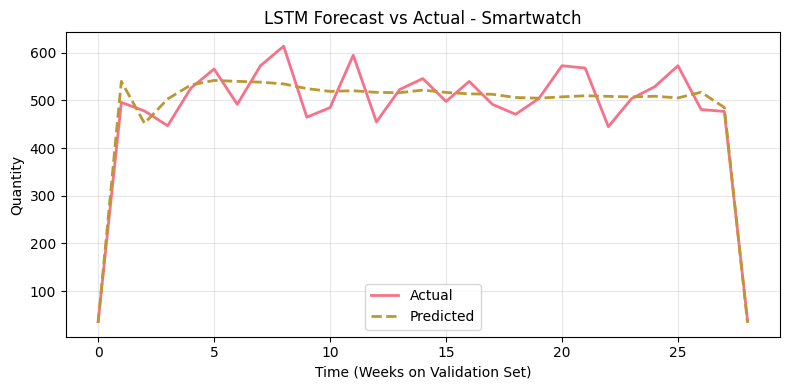


Đang đánh giá mô hình cho sản phẩm: Headphones
Kết quả Headphones:
    MSE  = 263.9060
    RMSE = 16.2452
    MAE  = 12.6642
    MAPE = 13.15%


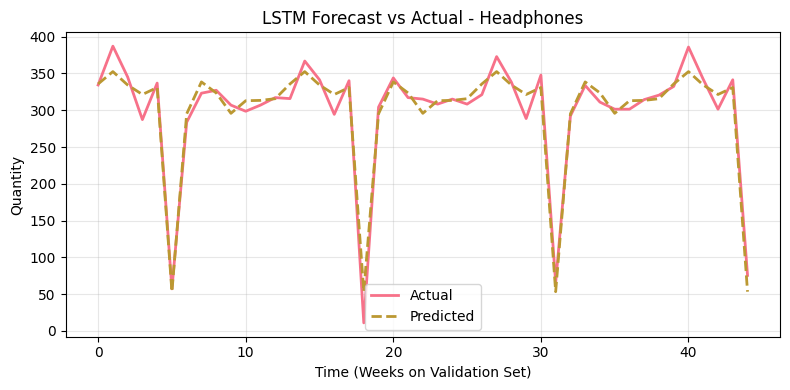


=== Tổng hợp kết quả LSTM cho toàn bộ sản phẩm ===


,Product Type,MSE,RMSE,MAE,MAPE
2,Smartphone,326.098419,18.058195,15.193612,2.380709
1,Laptop,604.110840,24.578666,17.592493,3.834831
0,Tablet,1208.662964,34.765830,23.800667,5.073655
3,Smartwatch,1786.019043,42.261319,34.924911,7.421766
4,Headphones,263.906036,16.245185,12.664242,13.148500


In [ ]:
# === EVALUATE ALL PRODUCT TYPES ===
results = []

for product in loaders_dict.keys():
    print("\n" + "="*80)
    print(f"Đang đánh giá mô hình cho sản phẩm: {product}")

    # Lấy val_loader từ loaders_dict
    val_loader = loaders_dict[product]["val_loader"]

    # TẢI LẠI ĐÚNG MÔ HÌNH VÀ SCALER TỪ DICTIONARY ĐÃ LƯU
    model_info = trained_models[product]

    # Khởi tạo kiến trúc model mới
    eval_model = LSTMRegressor(input_dim=model_info['input_dim']).to(DEVICE)

    # Tải trọng số đã huấn luyện
    eval_model.load_state_dict(model_info['model_state_dict'])

    # Lấy đúng scaler
    scaler_y = model_info['scaler_y']

    # === ĐÁNH GIÁ MÔ HÌNH ===
    # Sử dụng model và scaler vừa tải lại
    mse, rmse, mae, mape, y_true, y_pred = evaluate_metrics(eval_model, val_loader, scaler_y)

    print(f"Kết quả {product}:")
    print(f"    MSE  = {mse:.4f}")
    print(f"    RMSE = {rmse:.4f}")
    print(f"    MAE  = {mae:.4f}")
    print(f"    MAPE = {mape:.2f}%")

    results.append({
        "Product Type": product,
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "MAPE": mape
    })

    # === Biểu đồ Dự báo vs Thực tế ===
    plt.figure(figsize=(8,4))
    plt.plot(y_true, label='Actual', linewidth=2)
    plt.plot(y_pred, label='Predicted', linestyle='--', linewidth=2)
    plt.title(f"LSTM Forecast vs Actual - {product}")
    plt.xlabel("Time (Weeks on Validation Set)")
    plt.ylabel("Quantity")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# === Tổng hợp kết quả toàn bộ sản phẩm ===
results_df = pd.DataFrame(results)
print("\n=== Tổng hợp kết quả LSTM cho toàn bộ sản phẩm ===")
display(results_df.sort_values(by='MAPE'))

# 6. Model Comparison: SARIMA vs LSTM



In [ ]:
# ============================================================
# 8. SARIMA vs. LSTM Comparison for Each Product
# ============================================================

print("="*80)
print("COMPARING SARIMA VS. LSTM PERFORMANCE FOR EACH PRODUCT")
print("="*80)

# Create a comparison DataFrame
comparison_data = []

for product in product_types:
    # Get SARIMA metrics
    sarima_metrics = sarima_results['metrics'].get(product, {'MAE': np.nan, 'RMSE': np.nan, 'MAPE': np.nan})

    # Get LSTM metrics from results_df
    lstm_row = results_df[results_df['Product Type'] == product]
    if not lstm_row.empty:
        lstm_mae = lstm_row['MAE'].values[0]
        lstm_rmse = lstm_row['RMSE'].values[0]
        lstm_mape = lstm_row['MAPE'].values[0]
    else:
        lstm_mae = np.nan
        lstm_rmse = np.nan
        lstm_mape = np.nan

    comparison_data.append({
        'Product': product,
        'SARIMA_MAE': sarima_metrics['MAE'],
        'LSTM_MAE': lstm_mae,
        'SARIMA_RMSE': sarima_metrics['RMSE'],
        'LSTM_RMSE': lstm_rmse,
        'SARIMA_MAPE': sarima_metrics['MAPE'],
        'LSTM_MAPE': lstm_mape
    })

comparison_df = pd.DataFrame(comparison_data)

# Determine the best model for each product (based on lower MAPE)
comparison_df['Best_Model'] = comparison_df.apply(
    lambda row: 'SARIMA' if row['SARIMA_MAPE'] < row['LSTM_MAPE'] else 'LSTM',
    axis=1
)

# Display the detailed comparison table
print("\nDETAILED COMPARISON TABLE:")
print(comparison_df.to_string(index=False))

# Summary
print("\n" + "="*80)
print("BEST MODEL FOR EACH PRODUCT (based on MAPE):")
print("="*80)
for _, row in comparison_df.iterrows():
    better_model = row['Best_Model']
    mape_diff = abs(row['SARIMA_MAPE'] - row['LSTM_MAPE'])
    print(f"• {row['Product']:15} → {better_model:6} (MAPE: {row[f'{better_model}_MAPE']:.2f}%, better by {mape_diff:.2f}%)")

# Save comparison results
comparison_df.to_csv('model_comparison_results.csv', index=False)
print("\nComparison results saved to: model_comparison_results.csv")


COMPARING SARIMA VS. LSTM PERFORMANCE FOR EACH PRODUCT

DETAILED COMPARISON TABLE:
   Product  SARIMA_MAE  LSTM_MAE  SARIMA_RMSE  LSTM_RMSE  SARIMA_MAPE  LSTM_MAPE Best_Model
    Tablet   35.988234 23.800667    75.694518  34.765830    10.749546   5.073655       LSTM
    Laptop   34.646496 17.592493    54.747471  24.578666     9.978973   3.834831       LSTM
Smartphone   52.775464 15.193612    81.751846  18.058195     8.834794   2.380709       LSTM
Smartwatch   30.660639 34.924911    47.716023  42.261319     7.399316   7.421766     SARIMA
Headphones   61.789256 12.664242    74.812575  16.245185    30.545518  13.148500       LSTM

BEST MODEL FOR EACH PRODUCT (based on MAPE):
• Tablet          → LSTM   (MAPE: 5.07%, better by 5.68%)
• Laptop          → LSTM   (MAPE: 3.83%, better by 6.14%)
• Smartphone      → LSTM   (MAPE: 2.38%, better by 6.45%)
• Smartwatch      → SARIMA (MAPE: 7.40%, better by 0.02%)
• Headphones      → LSTM   (MAPE: 13.15%, better by 17.40%)

Comparison results saved t

## 6.1. Performance Comparison


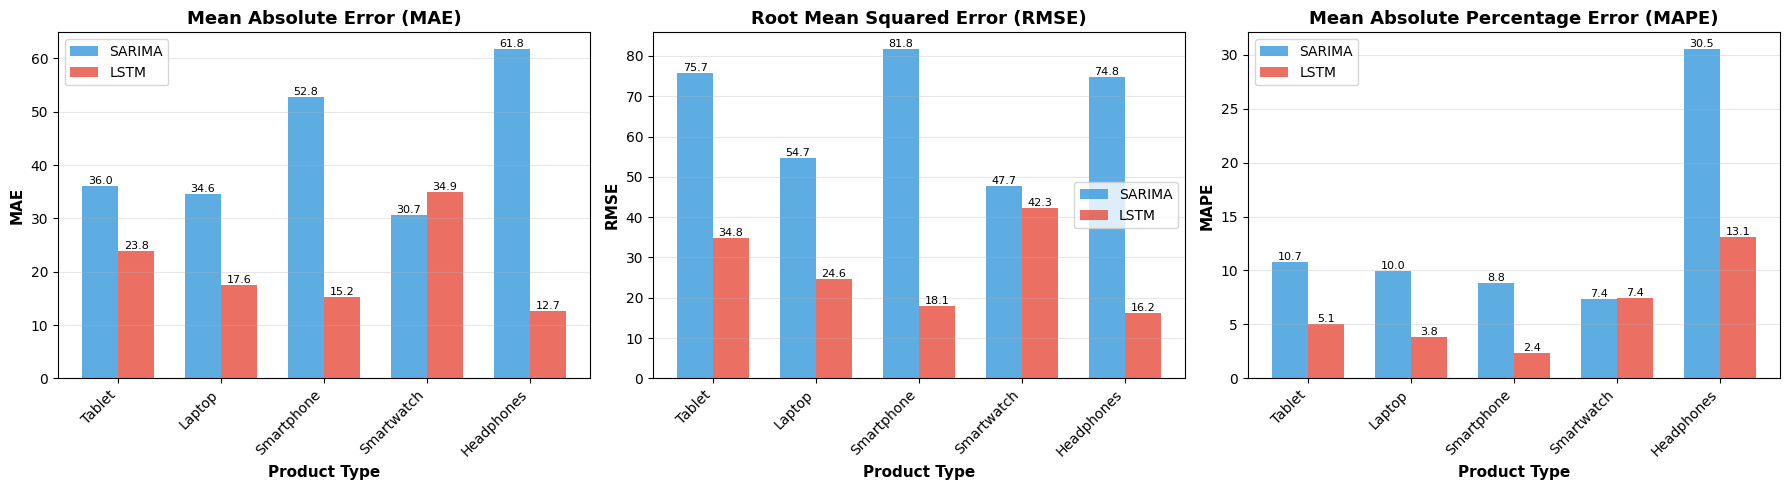

Comparison chart saved to: model_comparison_chart.png


In [ ]:
# ============================================================
# VISUAL COMPARISON CHART
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['MAE', 'RMSE', 'MAPE']
titles = ['Mean Absolute Error (MAE)', 'Root Mean Squared Error (RMSE)', 'Mean Absolute Percentage Error (MAPE)']

for idx, metric in enumerate(metrics):
    ax = axes[idx]

    x = np.arange(len(product_types))
    width = 0.35

    sarima_values = comparison_df[f'SARIMA_{metric}'].values
    lstm_values = comparison_df[f'LSTM_{metric}'].values

    bars1 = ax.bar(x - width/2, sarima_values, width, label='SARIMA', alpha=0.8, color='#3498db')
    bars2 = ax.bar(x + width/2, lstm_values, width, label='LSTM', alpha=0.8, color='#e74c3c')

    ax.set_xlabel('Product Type', fontsize=11, fontweight='bold')
    ax.set_ylabel(metric, fontsize=11, fontweight='bold')
    ax.set_title(titles[idx], fontsize=13, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(product_types, rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

    # Add values on top of each bar
    for bar in bars1:
        height = bar.get_height()
        if not np.isnan(height):
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.1f}', ha='center', va='bottom', fontsize=8)

    for bar in bars2:
        height = bar.get_height()
        if not np.isnan(height):
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.1f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('model_comparison_chart.png', dpi=300, bbox_inches='tight')
plt.show()

print("Comparison chart saved to: model_comparison_chart.png")


## 6.2. Visual Comparison


In [ ]:
# Number of weeks to forecast
FORECAST_WEEKS = 12

print("="*80)
print(f"FORECASTING {FORECAST_WEEKS} FUTURE WEEKS FOR EACH PRODUCT")
print("="*80)

# Dictionary to store forecast results
future_predictions = {}

for product in product_types:
    print(f"\n{'='*60}")
    print(f"Forecasting for: {product}")
    print(f"{'='*60}")

    # Get the best model
    best_model_row = comparison_df[comparison_df['Product'] == product]
    if best_model_row.empty:
        print(f"No information found for {product}")
        continue

    best_model = best_model_row['Best_Model'].values[0]
    print(f"Selected model: {best_model}")

    try:
        if best_model == 'SARIMA':
            # Forecast with SARIMA
            print("Using SARIMA model...")

            # Get the trained model
            model = sarima_results['models'][product]
            train_data = sarima_results['train_data'][product]
            test_data = sarima_results['test_data'][product]

            if model is None:
                print(f"SARIMA model for {product} is not available")
                continue

            # Refit the model on the entire dataset (train + test)
            full_data = pd.concat([train_data, test_data])
            order = sarima_results['params'][product][0]
            seasonal_order = sarima_results['params'][product][1]

            model_full = SARIMAX(full_data,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
            model_full_fitted = model_full.fit(disp=False)

            # Forecast 48 weeks
            forecast = model_full_fitted.forecast(steps=FORECAST_WEEKS)

            # Get the last date from the original, non-augmented data
            last_date = weekly_by_product['Purchase Date'].max()

            # Create a date index for the forecast (next 48 weeks)
            forecast_index = pd.date_range(start=last_date + pd.Timedelta(weeks=1),
                                          periods=FORECAST_WEEKS,
                                          freq='W')
            forecast_series = pd.Series(forecast.values, index=forecast_index)

        else:  # LSTM
            print("Using LSTM model...")

            # Get the model and scaler
            model_info = trained_models[product]

            # Initialize model
            model = LSTMRegressor(input_dim=model_info['input_dim']).to(DEVICE)
            model.load_state_dict(model_info['model_state_dict'])
            model.eval()

            # Get the most recent data to forecast from
            df_product = df_combined[df_combined['Product Type'] == product].copy()
            df_product = df_product.sort_values('Purchase Date').reset_index(drop=True)

            # Prepare the dataset
            dataset_full = TimeSeriesDataset(df_product, target_col='Quantity', seq_len=SEQ_LEN)

            # Sequential forecast (rolling forecast)
            last_sequence = dataset_full.X_seq[-1].unsqueeze(0).to(DEVICE)
            predictions = []

            with torch.no_grad():
                for _ in range(FORECAST_WEEKS):
                    # Predict the next step
                    pred = model(last_sequence).cpu().numpy()
                    predictions.append(pred[0, 0])

                    # Update the sequence (add new prediction, remove the first element)
                    # Note: This is a simplified version. In a real scenario, all features should be updated.
                    # Here, we demonstrate with the assumption that other features remain constant.
                    new_step = last_sequence[:, -1:, :].clone()
                    new_step[:, :, dataset_full.feature_cols.index('Quantity') if 'Quantity' in dataset_full.feature_cols else 0] = torch.tensor(pred)
                    last_sequence = torch.cat([last_sequence[:, 1:, :], new_step], dim=1)

            # Inverse transform
            predictions = np.array(predictions).reshape(-1, 1)
            predictions = np.expm1(model_info['scaler_y'].inverse_transform(predictions)).flatten()

            # Create a date index for the forecast
            last_date = pd.to_datetime(df_product['Purchase Date'].max())
            forecast_index = pd.date_range(start=last_date + pd.Timedelta(weeks=1),
                                          periods=FORECAST_WEEKS,
                                          freq='W')
            forecast_series = pd.Series(predictions, index=forecast_index)

        # Save results
        future_predictions[product] = {
            'model': best_model,
            'forecast': forecast_series,
            'mape': best_model_row[f'{best_model}_MAPE'].values[0]
        }

        print(f"Successfully forecasted for {product}")
        print(f"   Average predicted value: {forecast_series.mean():.2f}")
        print(f"   Min value: {forecast_series.min():.2f}, Max value: {forecast_series.max():.2f}")

    except Exception as e:
        print(f"Error while forecasting for {product}: {str(e)}")
        continue

print(f"\n{'='*80}")
print(f"Forecasting complete for {len(future_predictions)}/{len(product_types)} products")
print(f"{'='*80}")


FORECASTING 12 FUTURE WEEKS FOR EACH PRODUCT

Forecasting for: Tablet
Selected model: LSTM
Using LSTM model...
Successfully forecasted for Tablet
   Average predicted value: 480.89
   Min value: 446.87, Max value: 533.83

Forecasting for: Laptop
Selected model: LSTM
Using LSTM model...
Successfully forecasted for Laptop
   Average predicted value: 306.59
   Min value: 188.27, Max value: 404.69

Forecasting for: Smartphone
Selected model: LSTM
Using LSTM model...
Successfully forecasted for Smartphone
   Average predicted value: 564.08
   Min value: 373.16, Max value: 634.94

Forecasting for: Smartwatch
Selected model: SARIMA
Using SARIMA model...
Successfully forecasted for Smartwatch
   Average predicted value: 426.26
   Min value: 261.26, Max value: 563.23

Forecasting for: Headphones
Selected model: LSTM
Using LSTM model...
Successfully forecasted for Headphones
   Average predicted value: 254.01
   Min value: 227.17, Max value: 290.48

Forecasting complete for 5/5 products


# 7. Future Demand Forecasting



## 7.1. Generate 12-Week Forecasts


## 7.2. Visualize Forecast Results


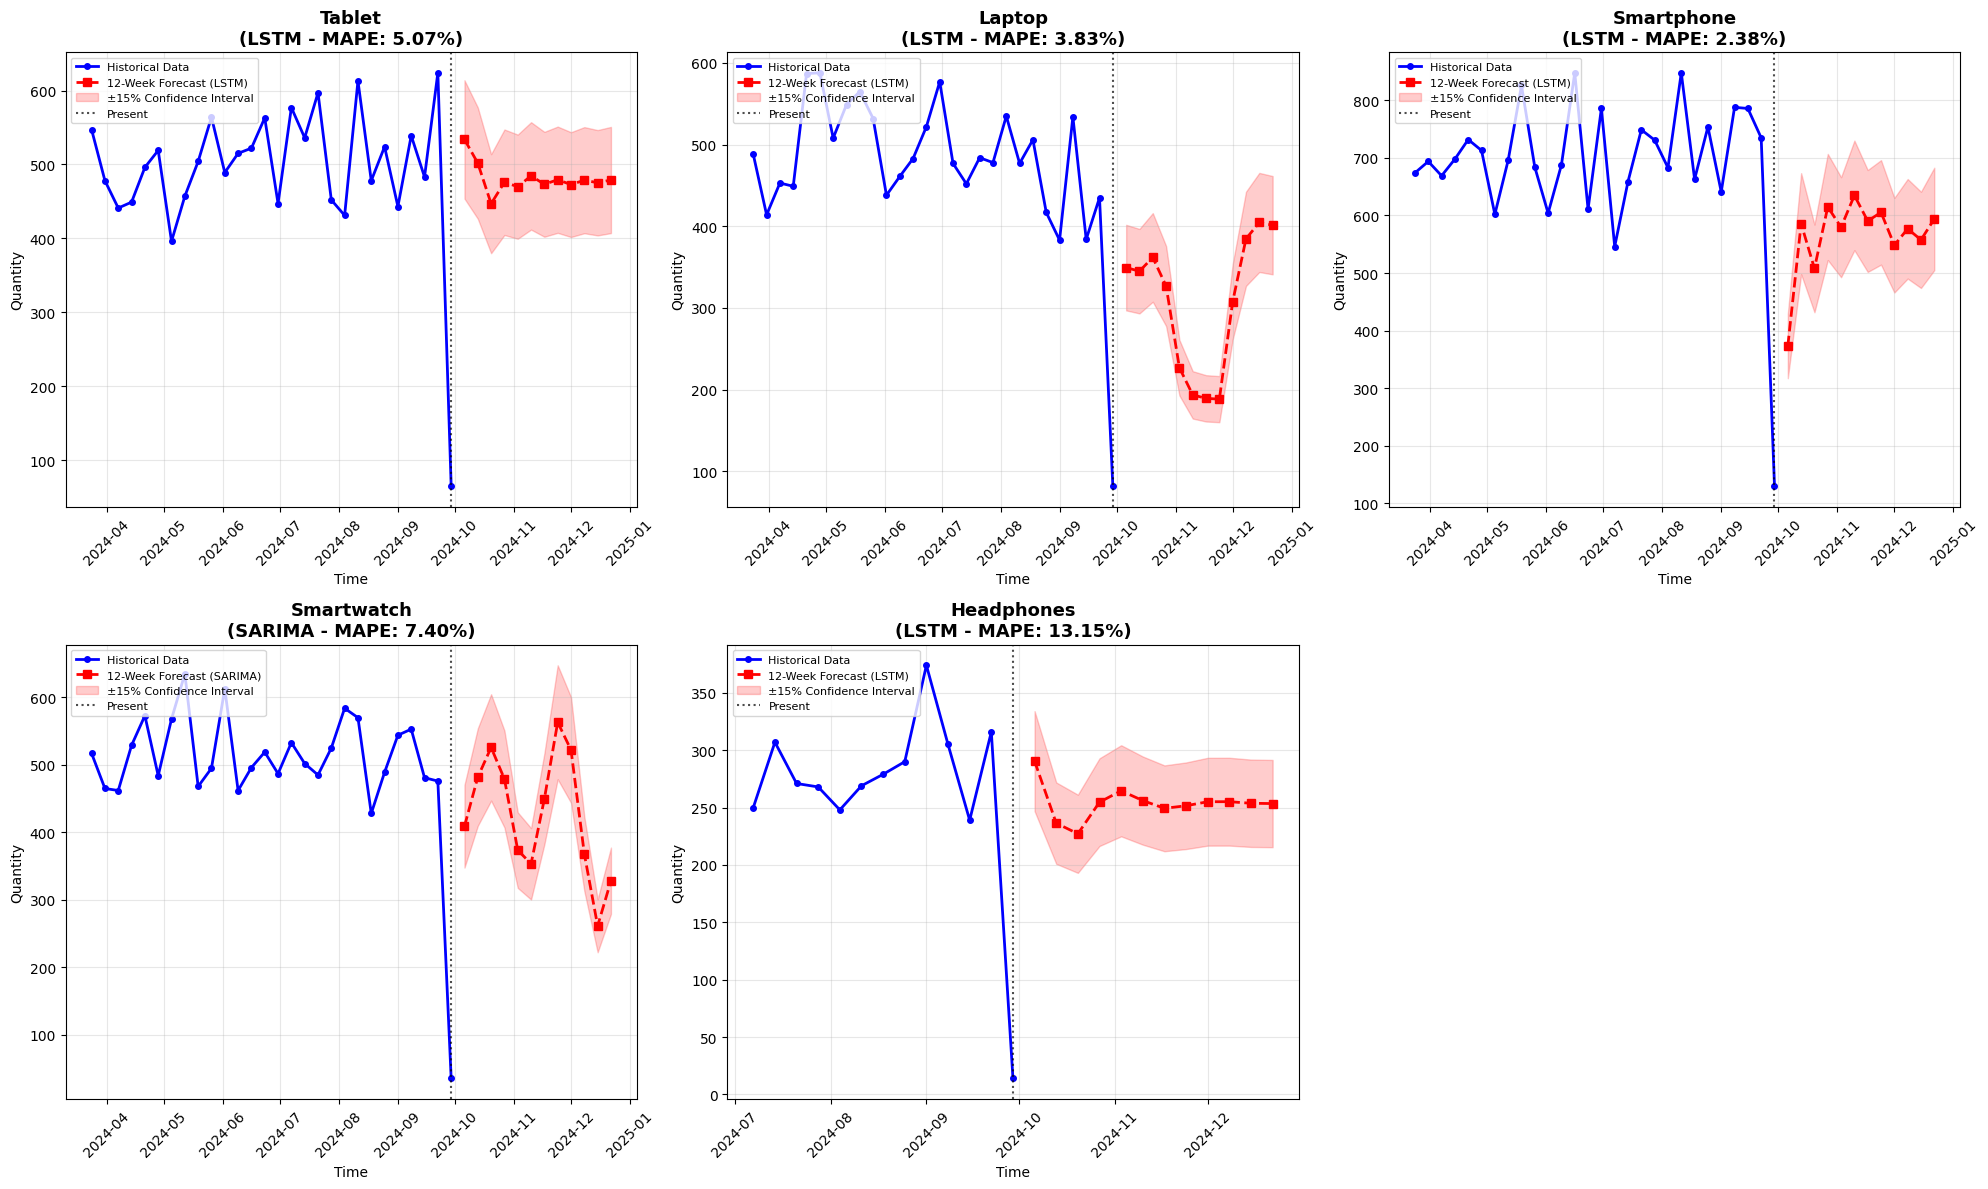

Future forecast chart saved to: future_forecast_12weeks.png


In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for idx, product in enumerate(product_types):
    ax = axes[idx]

    if product not in future_predictions:
        ax.text(0.5, 0.5, f'No prediction for {product}',
               ha='center', va='center', fontsize=12)
        ax.set_title(product, fontsize=14, fontweight='bold')
        continue

    pred_data = future_predictions[product]
    forecast_series = pred_data['forecast']
    model_name = pred_data['model']
    mape = pred_data['mape']

    # Get ORIGINAL historical data for plotting (always from weekly_by_product)
    df_product_original = weekly_by_product[weekly_by_product['Product Type'] == product].copy()
    historical_data = df_product_original.set_index('Purchase Date')['Quantity']

    # Only plot the last 30 weeks
    historical_plot = historical_data.tail(30)

    # Plot historical data
    ax.plot(historical_plot.index, historical_plot.values,
           label='Historical Data', color='blue', linewidth=2, marker='o', markersize=4)

    # Plot forecast
    ax.plot(forecast_series.index, forecast_series.values,
           label=f'12-Week Forecast ({model_name})', color='red',
           linewidth=2, linestyle='--', marker='s', markersize=6)

    # Confidence interval (optional - assuming ±15%)
    ax.fill_between(forecast_series.index,
                    forecast_series.values * 0.85,
                    forecast_series.values * 1.15,
                    alpha=0.2, color='red', label='±15% Confidence Interval')

    # Split line
    ax.axvline(x=historical_plot.index[-1], color='black',
              linestyle=':', linewidth=1.5, alpha=0.7, label='Present')

    ax.set_title(f'{product}\n({model_name} - MAPE: {mape:.2f}%)',
                fontsize=13, fontweight='bold')
    ax.set_xlabel('Time', fontsize=10)
    ax.set_ylabel('Quantity', fontsize=10)
    ax.legend(fontsize=8, loc='upper left')
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

# Remove any empty subplots
if len(product_types) < 6:
    for idx in range(len(product_types), 6):
        fig.delaxes(axes[idx])

plt.tight_layout()
plt.savefig('future_forecast_12weeks.png', dpi=300, bbox_inches='tight')
plt.show()

print("Future forecast chart saved to: future_forecast_12weeks.png")


## 7.3. Export Forecast Data


In [ ]:
# Create a DataFrame to hold all forecasts
all_forecasts = []

for product, pred_data in future_predictions.items():
    forecast_series = pred_data['forecast']
    model_name = pred_data['model']
    mape = pred_data['mape']

    for date, quantity in forecast_series.items():
        all_forecasts.append({
            'Product': product,
            'Date': date.strftime('%Y-%m-%d'),
            'Week': date.isocalendar()[1],
            'Year': date.year,
            'Predicted_Quantity': round(quantity, 2),
            'Model_Used': model_name,
            'Model_MAPE': round(mape, 2)
        })

forecast_df = pd.DataFrame(all_forecasts)

# Sort by Product and Date
forecast_df = forecast_df.sort_values(['Product', 'Date']).reset_index(drop=True)

# Save to file
forecast_df.to_csv('forecast_12weeks_results.csv', index=False)
forecast_df.to_excel('forecast_12weeks_results.xlsx', index=False)

print("="*80)
print("12-WEEK FORECAST TABLE FOR ALL PRODUCTS")
print("="*80)
print("\nData sample (first 5 rows of each product):")
for product in product_types:
    product_data = forecast_df[forecast_df['Product'] == product].head(5)
    if not product_data.empty:
        print(f"\n{product}:")
        print(product_data.to_string(index=False))

print("\n" + "="*80)
print("Forecast results saved to:")
print("   • CSV: forecast_12weeks_results.csv")
print("   • Excel: forecast_12weeks_results.xlsx")
print(f"   • Total: {len(forecast_df)} predictions ({len(future_predictions)} products × 12 weeks)")
print("="*80)


12-WEEK FORECAST TABLE FOR ALL PRODUCTS

Data sample (first 5 rows of each product):

Tablet:
Product       Date  Week  Year  Predicted_Quantity Model_Used  Model_MAPE
 Tablet 2024-10-06    40  2024              533.83       LSTM        5.07
 Tablet 2024-10-13    41  2024              501.78       LSTM        5.07
 Tablet 2024-10-20    42  2024              446.87       LSTM        5.07
 Tablet 2024-10-27    43  2024              475.87       LSTM        5.07
 Tablet 2024-11-03    44  2024              469.90       LSTM        5.07

Laptop:
Product       Date  Week  Year  Predicted_Quantity Model_Used  Model_MAPE
 Laptop 2024-10-06    40  2024              349.38       LSTM        3.83
 Laptop 2024-10-13    41  2024              345.02       LSTM        3.83
 Laptop 2024-10-20    42  2024              361.86       LSTM        3.83
 Laptop 2024-10-27    43  2024              326.80       LSTM        3.83
 Laptop 2024-11-03    44  2024              226.77       LSTM        3.83

Smartpho

# 8. Summary and Insights



## 8.1. Overall Summary


In [ ]:
print("="*80)
print("ANALYSIS AND FORECAST RESULTS SUMMARY")
print("="*80)

print("\n1. MODELS USED:")
print("   • SARIMA: Classic statistical model for time series with seasonality")
print("   • LSTM: Long Short-Term Memory neural network, learns complex patterns")

print("\n2. PERFORMANCE COMPARISON:")
sarima_count = (comparison_df['Best_Model'] == 'SARIMA').sum()
lstm_count = (comparison_df['Best_Model'] == 'LSTM').sum()
print(f"   • SARIMA performs better: {sarima_count}/{len(product_types)} products")
print(f"   • LSTM performs better: {lstm_count}/{len(product_types)} products")

print("\n3. DETAILED RESULTS BY PRODUCT:")
for _, row in comparison_df.iterrows():
    product = row['Product']
    best_model = row['Best_Model']
    sarima_mape = row['SARIMA_MAPE']
    lstm_mape = row['LSTM_MAPE']
    improvement = abs(sarima_mape - lstm_mape)

    print(f"\n   {product}:")
    print(f"      • SARIMA MAPE: {sarima_mape:.2f}%")
    print(f"      • LSTM MAPE: {lstm_mape:.2f}%")
    print(f"      • Best model: {best_model} (better by {improvement:.2f}%)")

    if product in future_predictions:
        avg_forecast = future_predictions[product]['forecast'].mean()
        print(f"      • Average forecast for next 48 weeks: {avg_forecast:.0f} units/week")

print("\n4. KEY INSIGHTS:")
# Find product with lowest MAPE
best_product = comparison_df.loc[comparison_df[['SARIMA_MAPE', 'LSTM_MAPE']].min(axis=1).idxmin()]
print(f"   • Most accurately predicted product: {best_product['Product']}")
print(f"     (MAPE: {min(best_product['SARIMA_MAPE'], best_product['LSTM_MAPE']):.2f}%)")

# Find product with highest MAPE
worst_product = comparison_df.loc[comparison_df[['SARIMA_MAPE', 'LSTM_MAPE']].min(axis=1).idxmax()]
print(f"   • Most difficult product to predict: {worst_product['Product']}")
print(f"     (MAPE: {min(worst_product['SARIMA_MAPE'], worst_product['LSTM_MAPE']):.2f}%)")

# Calculate forecast averages
if future_predictions:
    total_forecast = sum([pred['forecast'].sum() for pred in future_predictions.values()])
    print(f"\n   • Total projected demand for next 48 weeks: {total_forecast:,.0f} units")
    print(f"   • Weekly average: {total_forecast/48:,.0f} units")

print("\n5. GENERATED FILES:")
print("   • model_comparison_results.csv - Detailed SARIMA vs LSTM comparison")
print("   • model_comparison_chart.png - Metrics comparison chart")
print("   • future_forecast_48weeks.png - 48-week forecast visualization")
print("   • forecast_48weeks_results.csv - Forecast results in CSV format")
print("   • forecast_48weeks_results.xlsx - Forecast results in Excel format")

print("\n6. RECOMMENDATIONS:")
print("   • Use the best-performing model for each product")
print("   • Update data regularly to improve accuracy")
print("   • Consider external factors (promotions, seasonality) when planning")
print("   • Monitor forecast vs. actual performance for adjustments")

print("\n" + "="*80)
print("ANALYSIS AND FORECASTING COMPLETED")
print("="*80)


ANALYSIS AND FORECAST RESULTS SUMMARY

1. MODELS USED:
   • SARIMA: Classic statistical model for time series with seasonality
   • LSTM: Long Short-Term Memory neural network, learns complex patterns

2. PERFORMANCE COMPARISON:
   • SARIMA performs better: 1/5 products
   • LSTM performs better: 4/5 products

3. DETAILED RESULTS BY PRODUCT:

   Tablet:
      • SARIMA MAPE: 10.75%
      • LSTM MAPE: 5.07%
      • Best model: LSTM (better by 5.68%)
      • Average forecast for next 48 weeks: 481 units/week

   Laptop:
      • SARIMA MAPE: 9.98%
      • LSTM MAPE: 3.83%
      • Best model: LSTM (better by 6.14%)
      • Average forecast for next 48 weeks: 307 units/week

   Smartphone:
      • SARIMA MAPE: 8.83%
      • LSTM MAPE: 2.38%
      • Best model: LSTM (better by 6.45%)
      • Average forecast for next 48 weeks: 564 units/week

   Smartwatch:
      • SARIMA MAPE: 7.40%
      • LSTM MAPE: 7.42%
      • Best model: SARIMA (better by 0.02%)
      • Average forecast for next 48 wee